# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import random
import bisect
import warnings
import inflection

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
from matplotlib          import pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from sklearn.ensemble        import RandomForestClassifier

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix
from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#======================================== Rename DataFrame Columns ========================================#
def rename_columns(df01):
    # snakecase
    snakecase = lambda col: inflection.underscore(col)
    new_columns = list(map(snakecase, df01.columns))

    # rename
    df01.columns = new_columns
    
    return df01


#========================================== Statistical Summary ==========================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T
    iqr = pd.DataFrame(q75.reset_index(drop=True) - q25.reset_index(drop=True))

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = q25.reset_index(drop=True) - 1.5 * iqr.reset_index(drop=True)
    high_outliers = q75.reset_index(drop=True) + 1.5 * iqr.reset_index(drop=True)


    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q25, q75, q95, iqr, low_outliers, high_outliers, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '25%', '75%', '95%','IQR', 'Low Outliers', 'High Outliers', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m


#========================================== Cramer V (Correlation) ==========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



#========================================== Machine Learning Scores ==========================================#
def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name'            : model_name, 
                       'Precision'                : precision, 
                       'Recall'                   : recall,
                       'F1 Score'                 : f1,
                       'Kappa'                    : kappa,
                       'Balanced Accuracy'        : balanced_accuracy,
                       'Average Precision Score'  : ap,
                       'ROC AUC'                  : roc_auc}, index=[0])


#====================================== Machine Learning Cross Validation ======================================#
def cross_validation(X_train, y_train, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    model_name = type(model).__name__

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [5]:
df_raw = pd.read_csv('../01-Data/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 0.3.1 Saving Test Data

In [6]:
#Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['Exited']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# # Convert to .Feather Data
# train_dataset.to_feather('../01-Data/training_data.feather')
# test_dataset.to_feather('../01-Data/test_data.feather')

### 0.3.2 Read Training Dataset

In [7]:
df_train = pd.read_feather('../01-Data/training_data.feather')

# 1.0 DATA DESCRIPTION

In [8]:
df01 = df_train.copy()

## 1.1 Data Information

> - **RowNumber:**       Corresponds to the record (row) number;
> - **CustomerId:**      Contains unique identifier;
> - **Surname:**         Customer's surname;
> - **CreditScore:**     Customer's credit score for the consumer market;
> - **Geography:**       Customer’s country;
> - **Gender:**          Customer's gender;
> - **Age:**             Customer's age;
> - **Tenure:**          Number of years that the customer has been a client of the bank;
> - **Balance:**         The amount that the customer has in the bank account;
> - **NumOfProducts:**   Refers to the number of products that a customer has purchased through the bank;
> - **HasCrCard:**       Denotes whether or not a customer has a credit card;
> - **IsActiveMember:**  Denotes whether or not a customer is an active member;
> - **EstimatedSalary:** Estimate customer's annually income;
> - **Exited:**          Whether or not the customer is in Churn;

## 1.2 Columns

In [9]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### 1.2.1 Rename Columns

In [10]:
df01 = rename_columns(df01)

### 1.2.2 New Columns Name

In [11]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Dimensions

In [12]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 8000
Number of Columns: 14


## 1.4 Data Types

In [13]:
df01.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5 NA Check

In [14]:
df01.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.6 Check Balanced Data

In [15]:
df01['exited'].value_counts(normalize=True)

0    0.79625
1    0.20375
Name: exited, dtype: float64

In [16]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [17]:
statistical_summary(num_attributes.drop(['row_number', 'customer_id'], axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,credit_score,350.00,850.00,500.00,850.00,650.752500,652.000,489.0000,584.0000,717.000,812.000,133.0000,384.50000,916.50000,96.590394,0.148429,-0.079540,-0.418624
1,age,18.00,92.00,74.00,35.00,38.946625,37.000,25.0000,32.0000,44.000,60.000,12.0000,14.00000,62.00000,10.526219,0.270273,1.035706,1.459448
2,tenure,0.00,10.00,10.00,2.00,5.016625,5.000,1.0000,3.0000,8.000,9.000,5.0000,-4.50000,15.50000,2.896610,0.577402,0.013124,-1.172842
3,balance,0.00,238387.56,238387.56,0.00,76381.207499,97055.145,0.0000,0.0000,127633.195,162442.667,127633.1950,-191449.79250,319082.98750,62298.159597,0.815622,-0.141721,-1.492209
4,num_of_products,1.00,4.00,3.00,1.00,1.529500,1.000,1.0000,1.0000,2.000,2.000,1.0000,-0.50000,3.50000,0.581704,0.380323,0.755984,0.636943
5,has_cr_card,0.00,1.00,1.00,1.00,0.708750,1.000,0.0000,0.0000,1.000,1.000,1.0000,-1.50000,2.50000,0.454338,0.641042,-0.919091,-1.155561
6,is_active_member,0.00,1.00,1.00,1.00,0.514875,1.000,0.0000,0.0000,1.000,1.000,1.0000,-1.50000,2.50000,0.499779,0.970680,-0.059538,-1.996955
7,estimated_salary,11.58,199992.48,199980.90,24924.92,99730.811581,99446.940,9903.3685,50691.8175,148527.730,190113.789,97835.9125,-96062.05125,295281.59875,57331.532983,0.574863,0.007126,-1.174789
8,exited,0.00,1.00,1.00,0.00,0.203750,0.000,0.0000,0.0000,0.000,1.000,0.0000,0.00000,0.00000,0.402785,1.976860,1.471283,0.164715


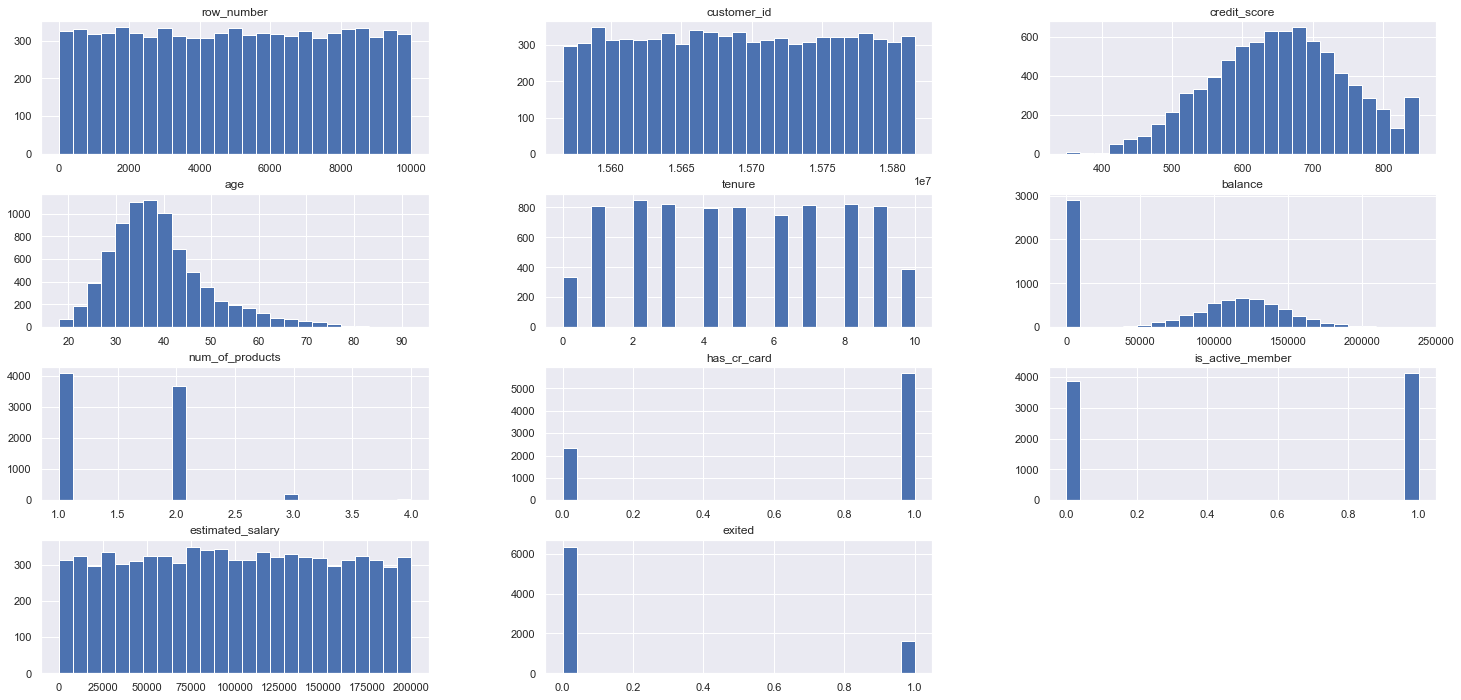

In [18]:
num_attributes.hist(bins=25);

### 1.6.2 Categorical Attributes

In [19]:
cat_attributes.describe()

,surname,geography,gender
count,8000,8000,8000
unique,2620,3,2
top,Smith,France,Male
freq,26,3993,4387


## 1.7 First Conclusions

> **age**
>> - The age range is large and it will be interesting to group by bands
>> - 50% are between 32 and 44 years (Adults)
>
> **balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - Almost 38% equals 0.00
>
> **credit_score**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **estimated_salary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a uniform distribution with great dispersion
>
> **has_cr_card**
>> - 75% has credit card
>
> **is_active_member**
>> - 50% of the customers has done a bank activity in the past 12 months
>
> **num_of_products**
>> - all customers have bought at least one product
>
> **tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>

>
> **exited**
>> - Customers in Churn: 20% (Disbalanced Dataset) 

# 2.0 FEATURE ENGINEERING

In [20]:
df02 = df01.copy()

In [21]:
# Tenure Vigency
df02['tenure_vigency'] = df02['tenure'] + 1

# tenure_vigency / age
df02['tenure_vigency_age'] = df02['tenure_vigency'] / df02['age']

# credit_score / tenure_vigency
df02['cred_score_tenure_vigency'] = df02['credit_score'] / df02['tenure_vigency']

# credit_score / age
df02['cred_age'] = df02['credit_score'] / df02['age']

# amount
df02['amount'] = df02['estimated_salary'] + df02['balance']

# amount / credit_score
df02['amount_credit'] = df02['amount'] / df02['credit_score']

# amount / tenure_vigency
df02['amount_tenure_vigency'] = df02['amount'] / df02['tenure_vigency']

# amount / num_of_products
df02['amount_num_of_products'] = df02['amount'] / df02['num_of_products']

# credit score / num_of_products
df02['cred_num_of_products'] = df02['credit_score'] / df02['num_of_products']

# balance / tenure_vigency
df02['bal_tenure_vigency'] = df02['balance'] / df02['tenure_vigency']

# num_of_products - credit card
df02['num_of_products_has_cr_card_sub'] = df02['num_of_products'] - df02['has_cr_card']

# num_of_products * credit card
df02['num_of_products_has_cr_card_mul'] = df02['num_of_products'] * df02['has_cr_card']

# tenure_vigency_age * balance
df02['tenure_vigency_age_balance'] = df02['tenure_vigency_age'] * df02['balance']

# balance * is_active_member
df02['balance_is_active_member'] = df02['balance'] * df02['is_active_member']

# Group Age
df02['age_group'] = df02['age'].apply(lambda row: age_stage(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)




#################### tenure_vigency Mean, Median, Std, Max, Min
df02['tenure_vigency_mean'] = df02['tenure_vigency'] / df02['tenure_vigency'].mean()
df02['tenure_vigency_median'] = df02['tenure_vigency'] / df02['tenure_vigency'].median()
df02['tenure_vigency_std'] = df02['tenure_vigency'] / df02['tenure_vigency'].std()
df02['tenure_vigency_max'] = df02['tenure_vigency'] / df02['tenure_vigency'].max()
df02['tenure_vigency_min'] = df02['tenure_vigency'] / df02['tenure_vigency'].min()

# credit_score Mean, Median, Std, Max, Min
df02['credit_score_mean'] = df02['credit_score'] / df02['credit_score'].mean()
df02['credit_score_median'] = df02['credit_score'] / df02['credit_score'].median()
df02['credit_score_std'] = df02['credit_score'] / df02['credit_score'].std()
df02['credit_score_max'] = df02['credit_score'] / df02['credit_score'].max()
df02['credit_score_min'] = df02['credit_score'] / df02['credit_score'].min()

# amount Mean, Median, Std, Max, Min
df02['amount_mean'] = df02['amount'] / df02['amount'].mean()
df02['amount_median'] = df02['amount'] / df02['amount'].median()
df02['amount_std'] = df02['amount'] / df02['amount'].std()
df02['amount_max'] = df02['amount'] / df02['amount'].max()
df02['amount_min'] = df02['amount'] / df02['amount'].min()

# balance Mean, Median, Std, Max, Min
df02['balance_mean'] = df02['balance'] / df02['balance'].mean()
df02['balance_median'] = df02['balance'] / df02['balance'].median()
df02['balance_std'] = df02['balance'] / df02['balance'].std()
df02['balance_max'] = df02['balance'] / df02['balance'].max()
df02['amount_min'] = df02['balance'] / df02['balance'][df02['balance'] > 0.0].min()

# 3.0 BALANCED DATASET

In [22]:
df03 = df02.copy()

## 3.4 SMOTE + TOMEKLINK

In [23]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df03.select_dtypes(include=['int64', 'float64']).drop('exited', axis=1).columns.tolist()

# Categorical
col_cat = df03.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df03_dummy = pd.DataFrame(ohe.fit_transform(df03[col_cat]).toarray(), index=df03.index)

# join Numerical and Categorical
df03_1 = pd.concat([df03[col_num], df03_dummy], axis=1)

In [24]:
ratio_balanced = {
                    0: 7963,
                    1: 3*2037
                }

ratio_balanced

{0: 7963, 1: 6111}

In [25]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df03_1, df03['exited'])

In [26]:
# numerical data
df03_2 = X_smt[col_num]

# categorical data
df03_3 = X_smt.drop(col_num, axis=1)
df03_4 = pd.DataFrame(ohe.inverse_transform(df03_3), columns=col_cat, index=df03_3.index)

# join numerical and categorical
df03_5 = pd.concat([df03_2, df03_4], axis=1)
df03_5['exited'] = y_smt

# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

In [27]:
df04_u = df03.copy()
df04 = df03_5.copy()

## 4.1 Mind Map

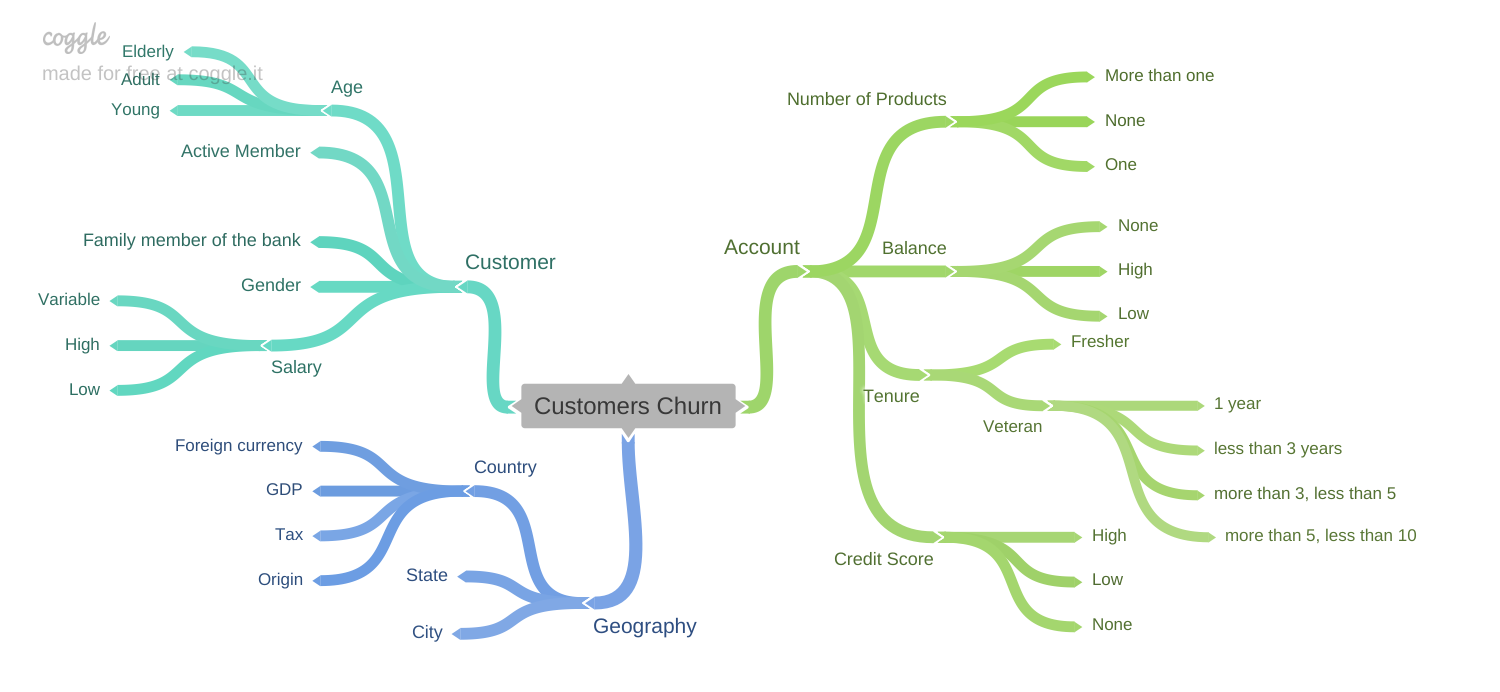

In [28]:
Image('../img/01-FirstCycleCRISPCostumerChurn.png')

## 4.2 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Customers with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Churn should occur for customers with high salary
>> - H07 - Churn should occur for customers with high balance
>
> **Geography**
>> - H01 - Countries with higher GDP should have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin should have higher number of churn
>
> **Account**
>> - H01 - Active members should have less churn
>> - H02 - Active members should have more products
>> - H03 - The more products the customer has, the less likely it is to go into churn
>> - H04 - Customers with credit cards are more active
>> - H05 - Churn should occur for customers with low tenur
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

## 4.3 Response Variable

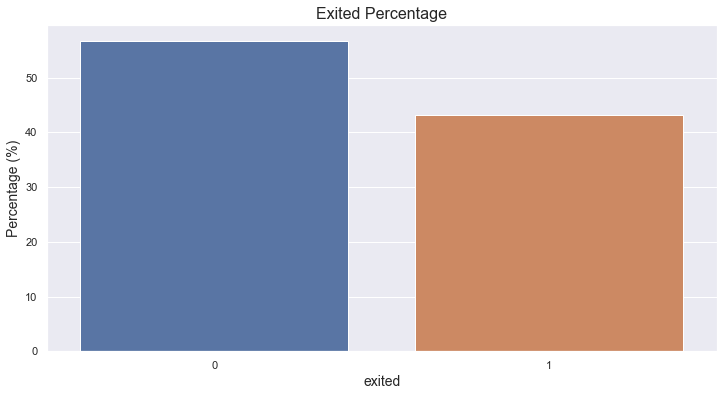

In [29]:
exited_percentage = df04['exited'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=exited_percentage.index, y=exited_percentage);
plt.ylabel('Percentage (%)', fontsize=14);
plt.xlabel('exited', fontsize=14);
plt.title('Exited Percentage', fontsize=16);

## 4.4 Univariate Analysis

### 4.4.1 Numerical Attributes

In [30]:
num_attributes = df04.select_dtypes(include=['int64', 'float64'])
statistical_summary(num_attributes)

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,row_number,1.000000e+00,1.000000e+04,9999.000000,4.618000e+03,4.966342e+03,4.942500e+03,6.970500e+02,2.750250e+03,7.193000e+03,9.266000e+03,4442.750000,-3.913875e+03,1.385712e+04,2677.127259,0.539054,0.015705,-1.077177
1,customer_id,1.556570e+07,1.581569e+07,249989.000000,1.564430e+07,1.569049e+07,1.568947e+07,1.558060e+07,1.562782e+07,1.575385e+07,1.580144e+07,126024.250000,1.543878e+07,1.594288e+07,71930.521248,0.004584,0.018592,-1.224834
2,credit_score,3.500000e+02,8.500000e+02,500.000000,8.500000e+02,6.493553e+02,6.510000e+02,4.990000e+02,5.870000e+02,7.110000e+02,7.999500e+02,124.000000,4.010000e+02,8.970000e+02,90.420003,0.139246,-0.075970,-0.316429
3,age,1.800000e+01,9.200000e+01,74.000000,3.800000e+01,4.041750e+01,3.900000e+01,2.600000e+01,3.300000e+01,4.600000e+01,5.895000e+01,13.000000,1.350000e+01,6.550000e+01,9.992692,0.247237,0.692158,0.722834
4,tenure,0.000000e+00,1.000000e+01,10.000000,5.000000e+00,4.869188e+00,5.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00,9.000000e+00,4.000000,-3.000000e+00,1.300000e+01,2.768008,0.568474,0.016815,-1.084293
5,balance,0.000000e+00,2.383876e+05,238387.560000,0.000000e+00,8.129129e+04,1.032735e+05,0.000000e+00,0.000000e+00,1.286639e+05,1.615868e+05,128663.877500,-1.929958e+05,3.216597e+05,60904.062219,0.749208,-0.308364,-1.392166
6,num_of_products,1.000000e+00,4.000000e+00,3.000000,1.000000e+00,1.487757e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000,-5.000000e-01,3.500000e+00,0.606435,0.407617,0.985090,0.676381
7,has_cr_card,0.000000e+00,1.000000e+00,1.000000,1.000000e+00,6.116455e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000,-1.500000e+00,2.500000e+00,0.487376,0.796827,-0.458200,-1.790314
8,is_active_member,0.000000e+00,1.000000e+00,1.000000,0.000000e+00,4.460720e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000,-1.500000e+00,2.500000e+00,0.497083,1.114357,0.217001,-1.953195
9,estimated_salary,1.158000e+01,1.999925e+05,199980.900000,2.492492e+04,1.008143e+05,1.020523e+05,1.055463e+04,5.229136e+04,1.500550e+05,1.888086e+05,97763.628310,-9.435408e+04,2.967004e+05,57252.011031,0.567896,-0.034283,-1.192711


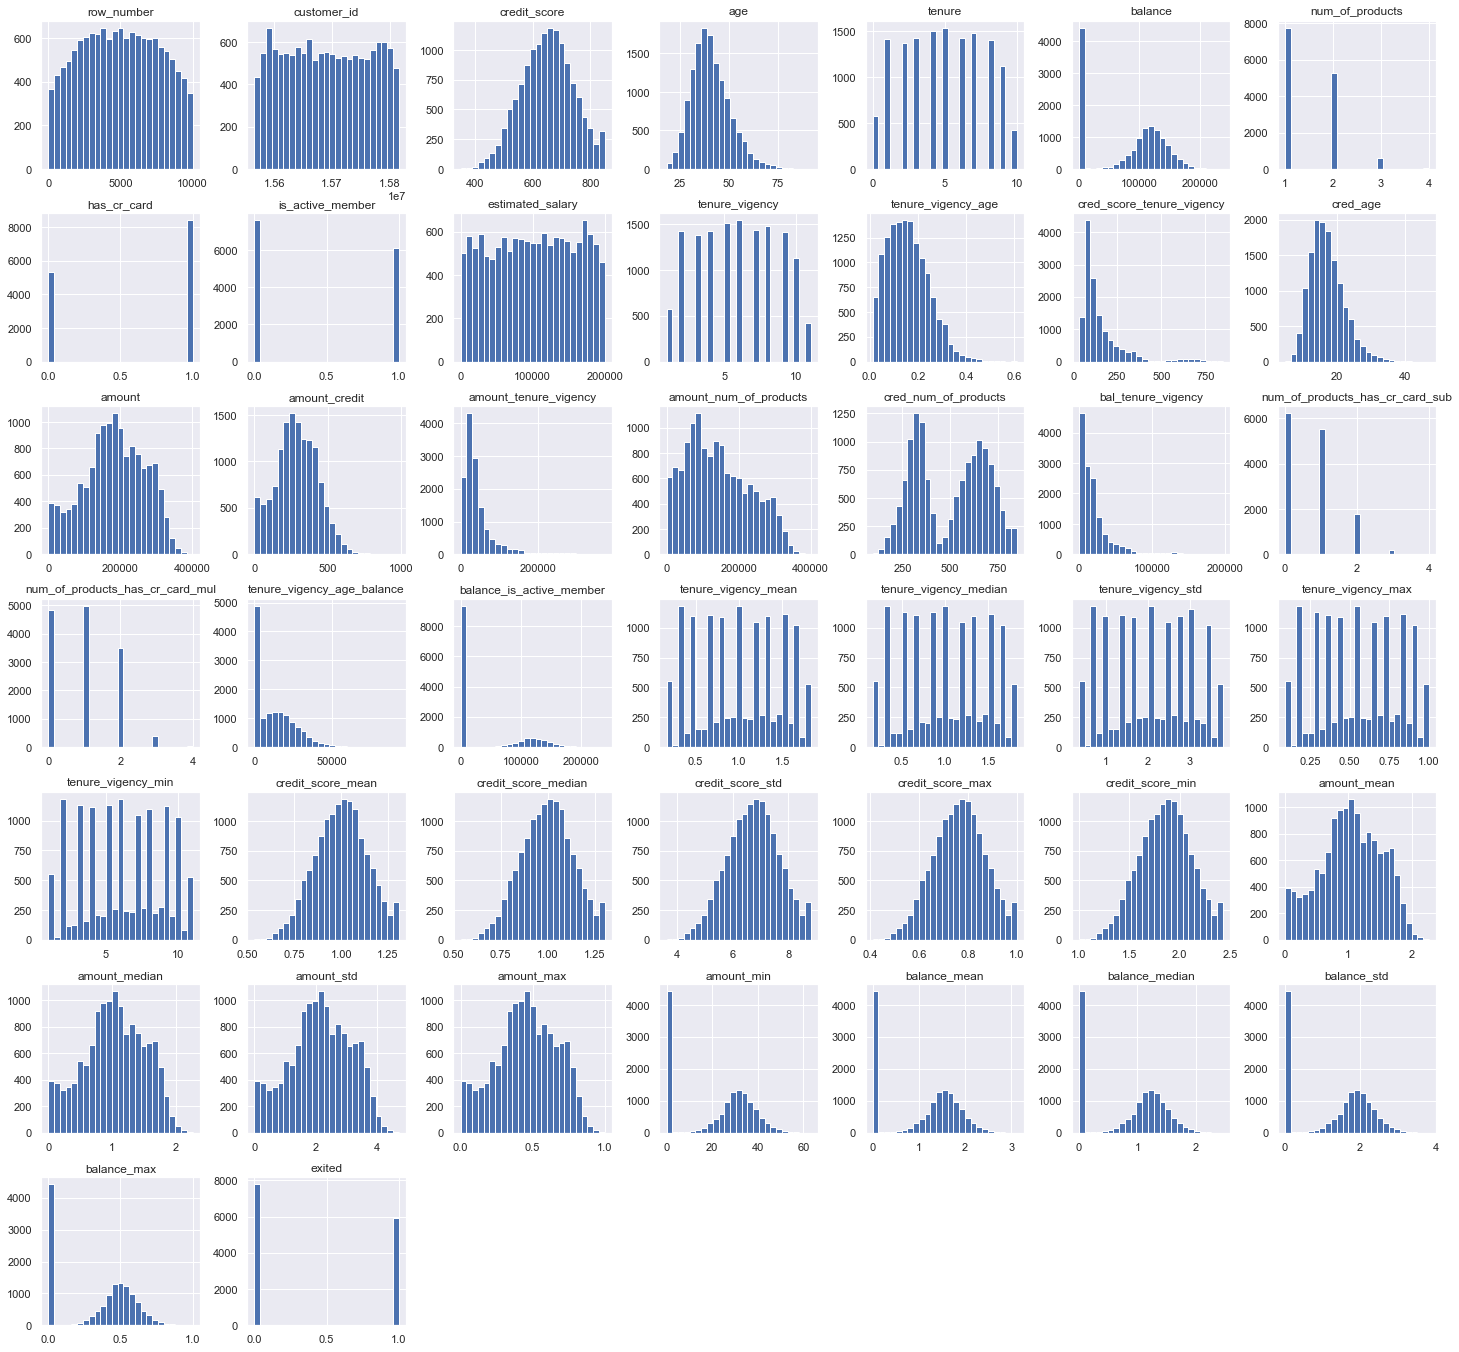

In [31]:
num_attributes.hist(bins=25, figsize=(25,24));

### 4.4.2 Categorical Attributes

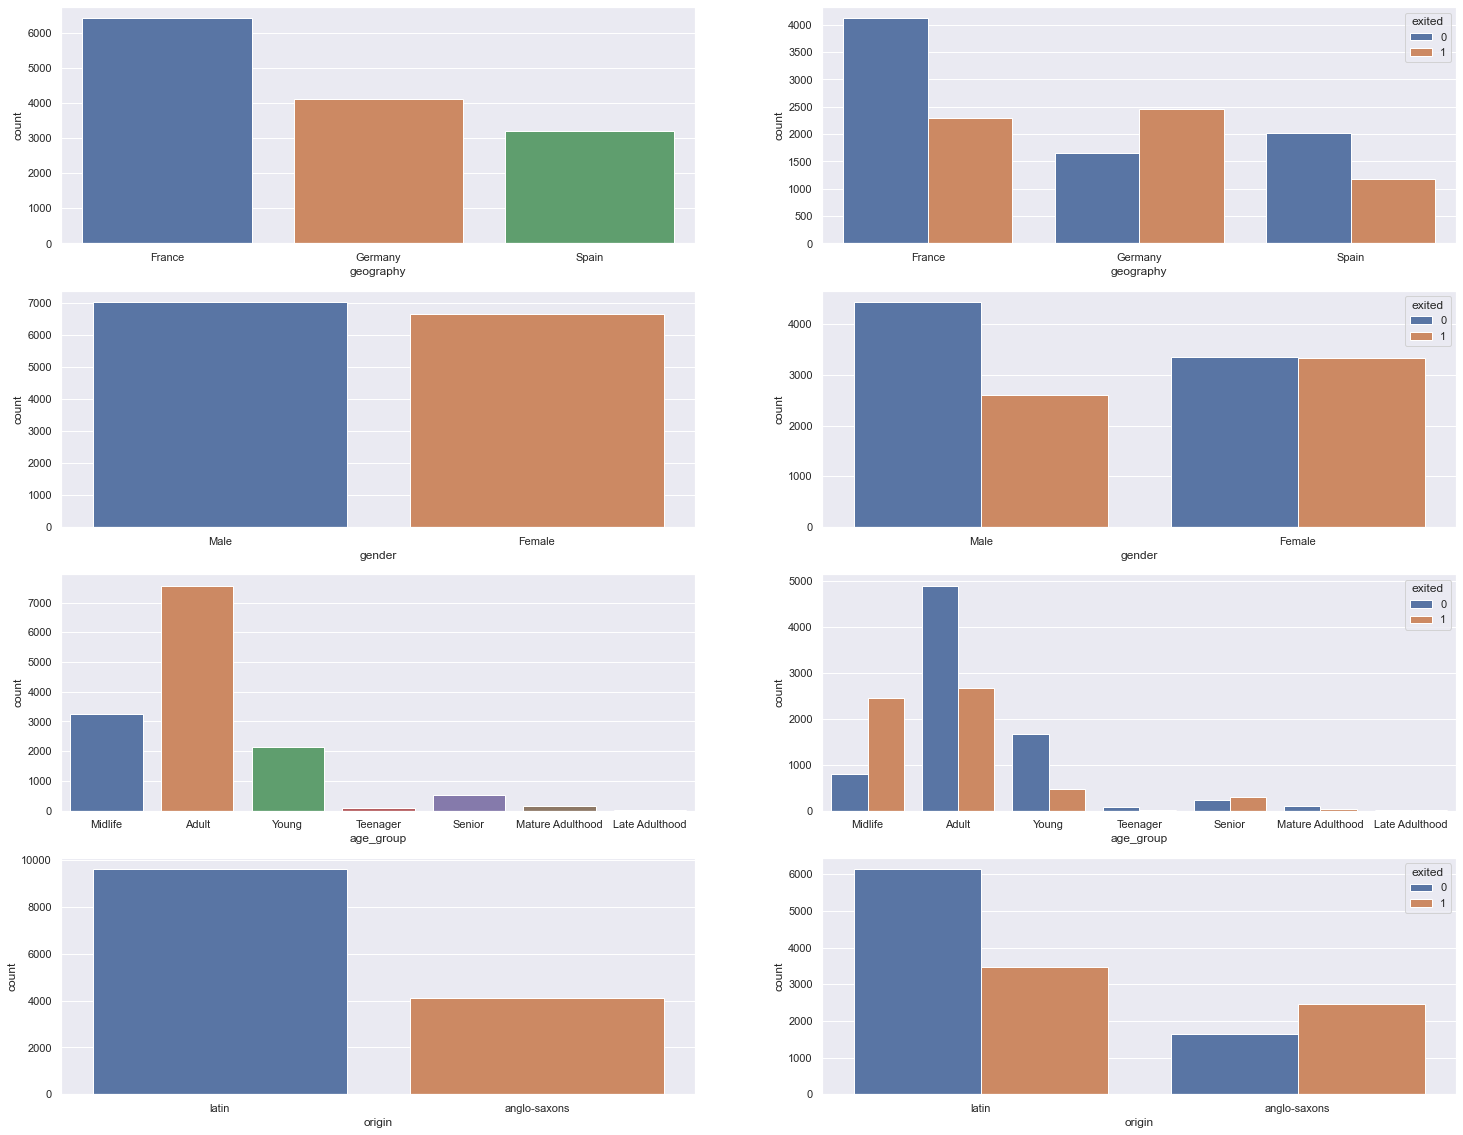

In [32]:
cat_attributes = df04.select_dtypes(include=['object']).drop('surname', axis=1)

count = 1
rows= len(cat_attributes.columns)
plt.figure(figsize=(25,5*rows))
for i in cat_attributes:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df04)
    count += 1
plt.show()

## 4.5 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 4.5.1 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

### H01 - Men usually have more churn
---
> - Conclusion: **FALSE** 
>> **WOMEN** have more churn

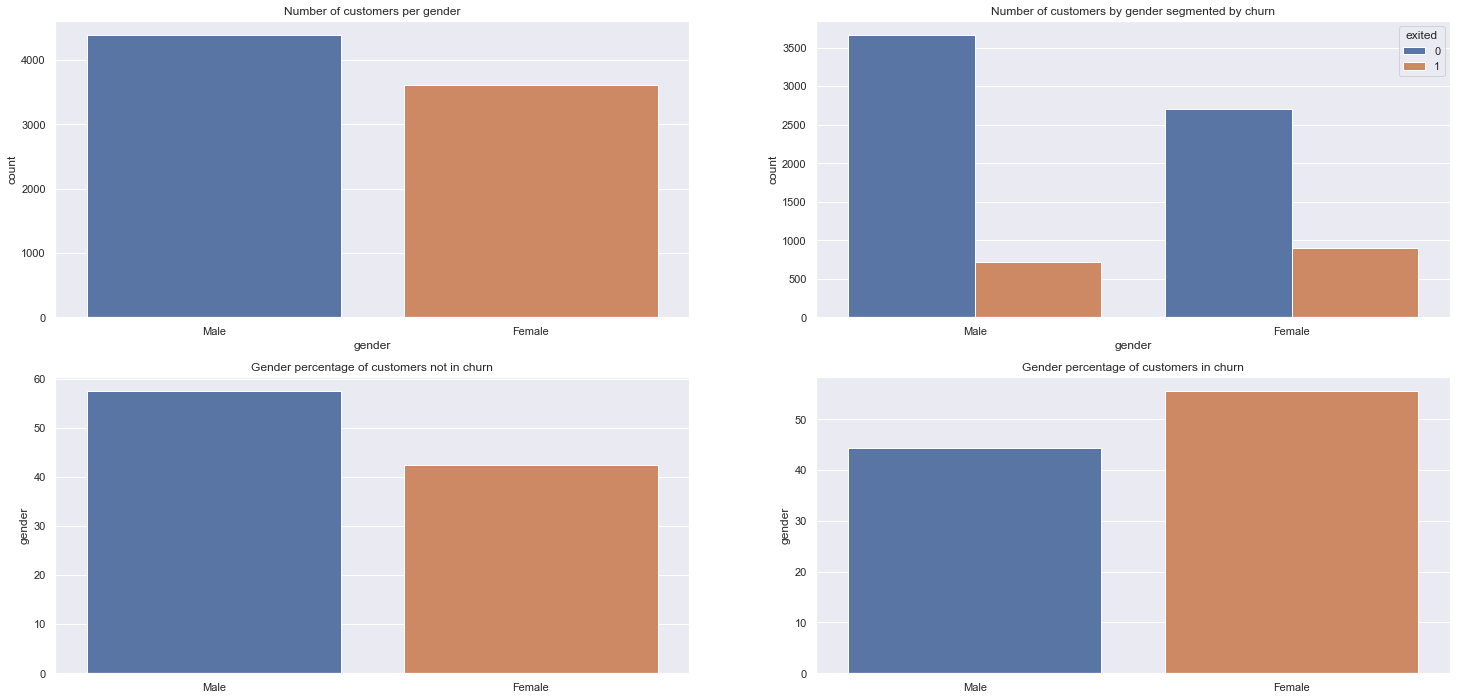

In [33]:
plt.subplot(2,2,1)
sns.countplot(x='gender', order=['Male', 'Female'], data=df04_u).set_title('Number of customers per gender');

plt.subplot(2,2,2)
sns.countplot(x='gender', hue='exited', order=['Male', 'Female'], data=df04_u).set_title('Number of customers by gender segmented by churn');

plt.subplot(2,2,3)
gender_percentage_not_churn = df04_u[df04_u['exited'] == 0]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_not_churn.index, y=gender_percentage_not_churn, order=['Male', 'Female']).set_title('Gender percentage of customers not in churn');

plt.subplot(2,2,4)
gender_percentage_churn = df04_u[df04_u['exited'] == 1]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_churn.index, y=gender_percentage_churn, order=['Male', 'Female']).set_title('Gender percentage of customers in churn');

### H02 - Younger clients are less loyal and more likely to leave a bank
---
> - Conclusion: **FALSE** 
>> Younger clients are **MORE** loyal and more likely to leave a bank

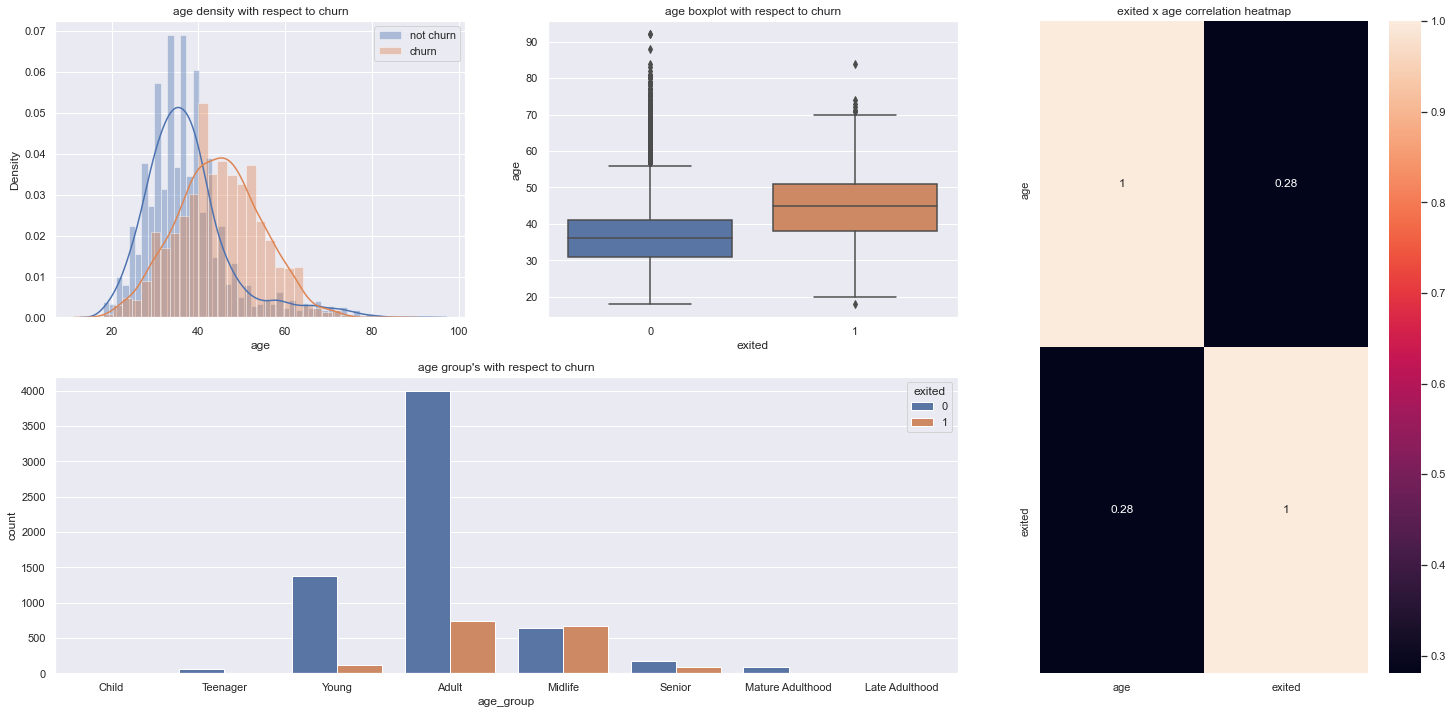

In [34]:
aux02 = df04_u[['age', 'age_group', 'exited']]

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
#sns.histplot(x='age', bins=25, hue='exited', data=aux01);
sns.distplot(aux02[aux02['exited'] == 0]['age'], label='not churn');
sns.distplot(aux02[aux02['exited'] == 1]['age'], label='churn');
plt.title("age density with respect to churn");
plt.legend();

plt.subplot(grid[0,1])
sns.boxplot(x='exited', y='age', data=aux02).set_title("age boxplot with respect to churn");

plt.subplot(grid[1,:2])
sns.countplot(x='age_group', hue='exited', order=['Child', 'Teenager', 'Young',
                                                  'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood'], data=aux02);
plt.title("age group's with respect to churn");

plt.subplot(grid[:,2])
sns.heatmap(aux02.corr(method='pearson'),annot=True).set_title("exited x age correlation heatmap");

### H03 - Churn should occur for customers with high salary
---
> - Conclusion: **TRUE** 
>> Churn occur for clients with high salary

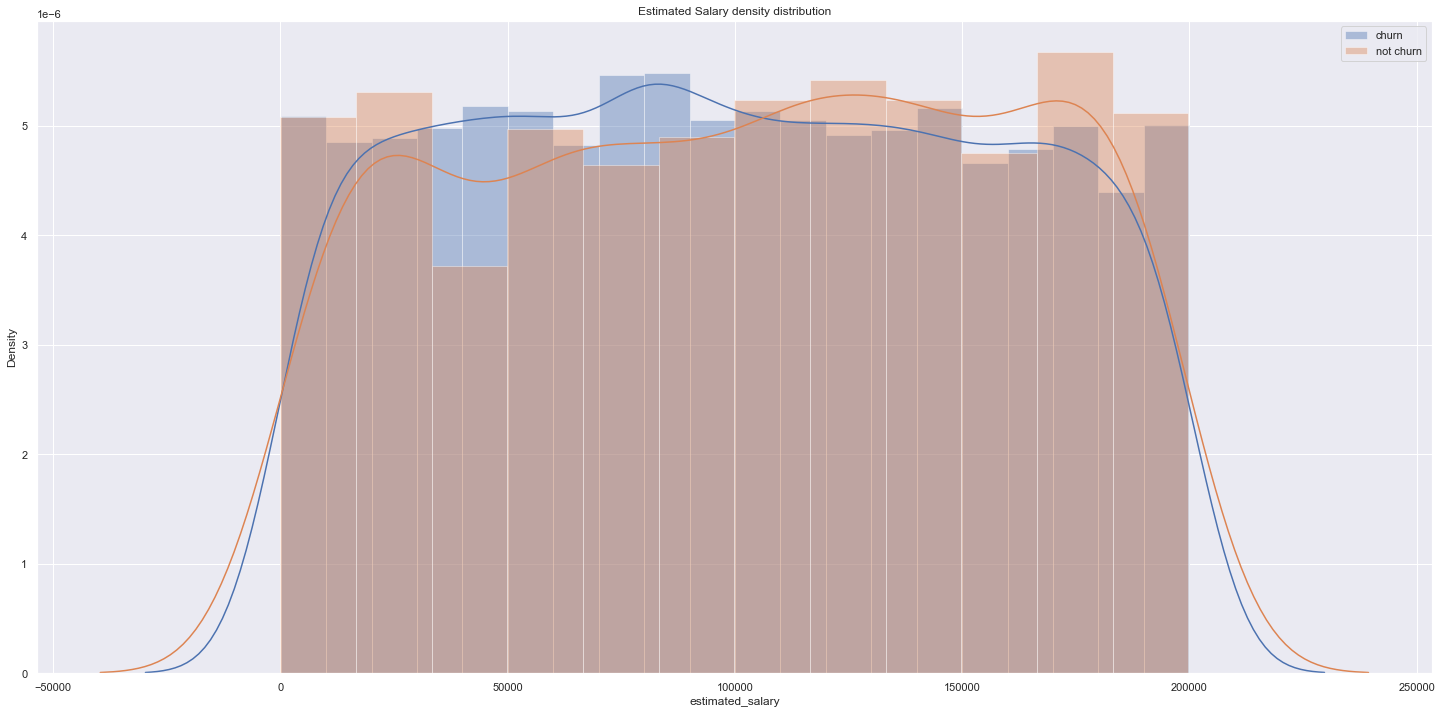

In [35]:
sns.distplot(df04_u[df04_u['exited'] == 0]['estimated_salary'], kde=True, label='churn')
sns.distplot(df04_u[df04_u['exited'] == 1]['estimated_salary'], kde=True, label='not churn')
plt.title('Estimated Salary density distribution');
plt.legend();

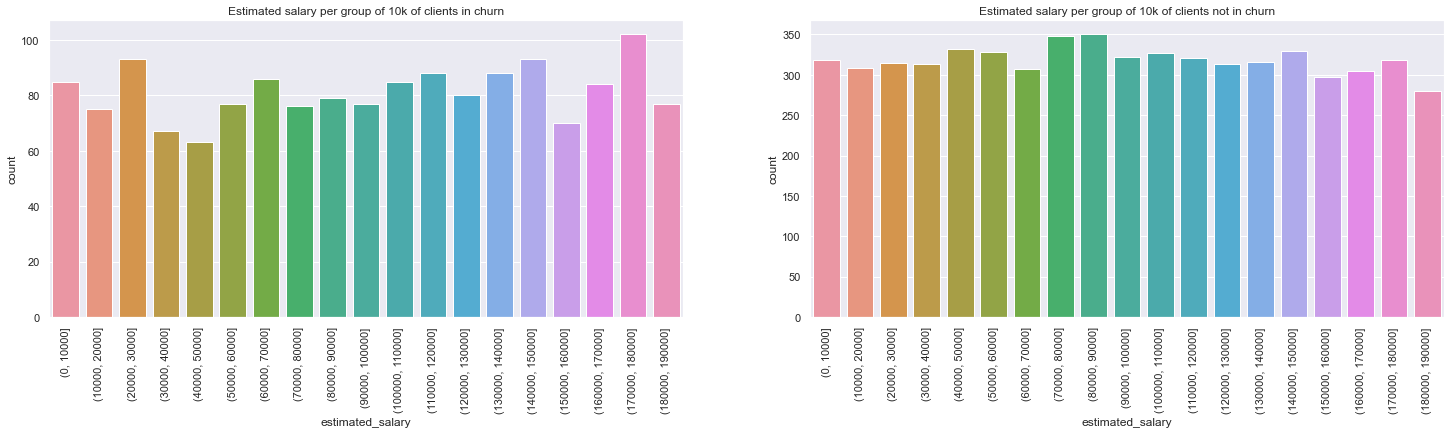

In [36]:
bins = list(np.arange(0, 200000, 10000))

aux03_churn = pd.cut(df04_u[df04_u['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04_u[df04_u['exited'] == 0]['estimated_salary'], bins=bins)

plt.subplot(2,2,1)
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=90);

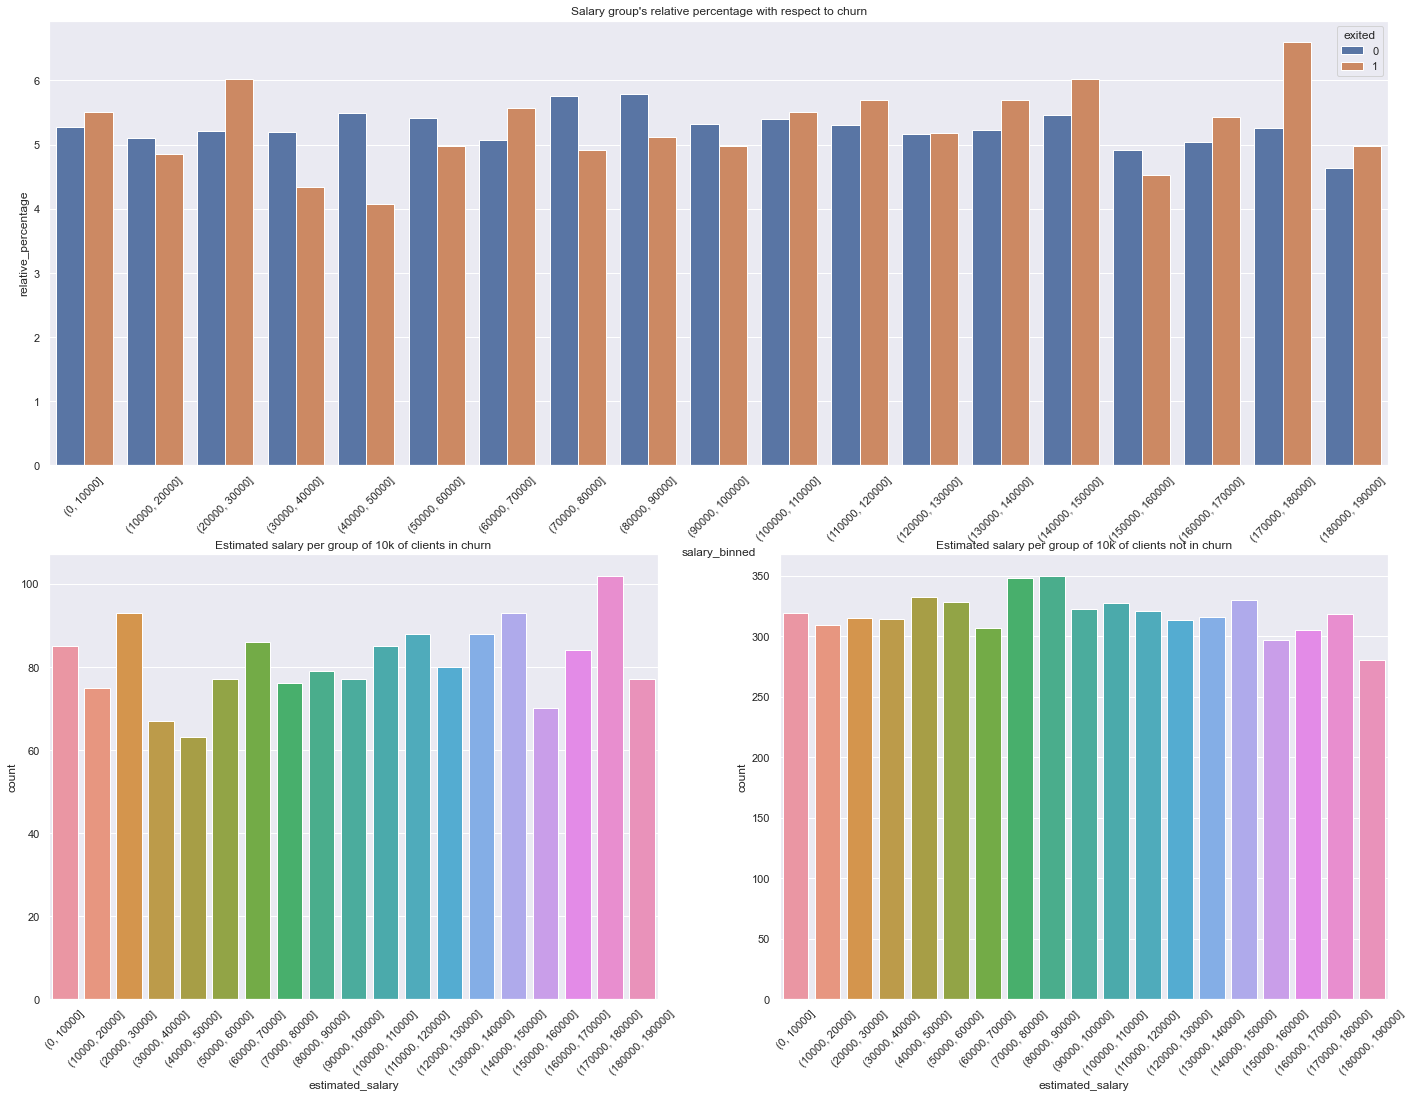

In [37]:
# bins
bins = list(np.arange(0, 200000, 10000))

# create new dataframe
aux03 = df04_u[['estimated_salary', 'exited']]
aux03['salary_binned'] = pd.cut(aux03['estimated_salary'], bins=bins)

# salary_binned, exited and number of clients
aux03 = aux03[['salary_binned', 'estimated_salary', 'exited']].groupby(['salary_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux03.columns = ['salary_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux03_churn = aux03[aux03['exited'] == 1]['customers'].sum()
aux03_not_churn = aux03[aux03['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux03['relative_percentage'] = aux03.\
apply(lambda row: ((row['customers'] / aux03_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux03_not_churn)*100), axis=1)


# Grid for ploting
plt.figure(figsize=(24,18))
grid = GridSpec(2, 2)

# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[0,:])
sns.barplot(x='salary_binned', y='relative_percentage', hue='exited', data=aux03).set_title("Salary group's relative percentage with respect to churn");
plt.xticks(rotation=45);

# New auxiliary analyses for plot
aux03_churn = pd.cut(df04_u[df04_u['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04_u[df04_u['exited'] == 0]['estimated_salary'], bins=bins)

# plot Estimated salary per group of 10k of clients in churn
plt.subplot(grid[1,0])
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=45);

# plot Estimated salary per group of 10k of clients not in churn
plt.subplot(grid[1,1])
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=45);

### H04 - Churn should occur for customers with high balance
---
> - Conclusion: **TRUE** 
>> Churn occur for customers with high balance

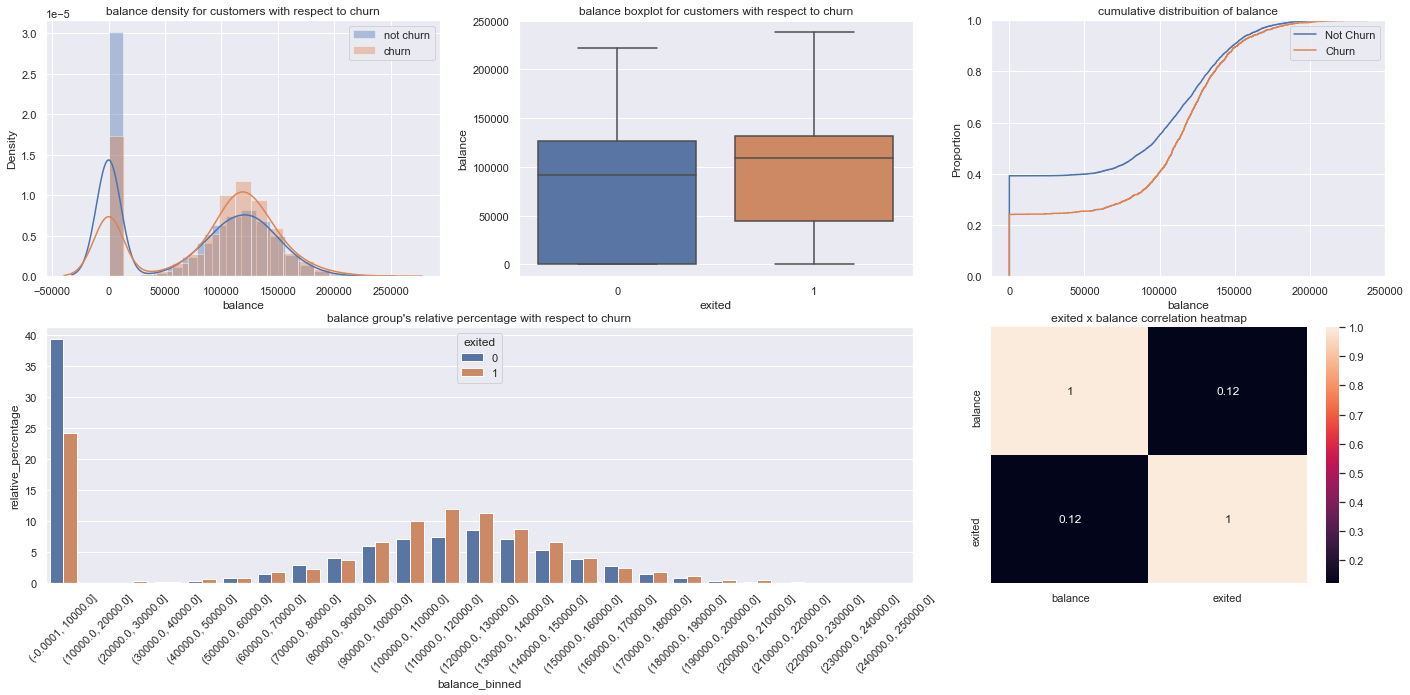

In [38]:
# bins
bins = list(np.arange(-0.0001, 250000, 10000))

# create new dataframe
aux04 = df04_u[['balance', 'exited']]

# Grid for ploting
plt.figure(figsize=(24,16))
grid = GridSpec(3, 3)

# balance density
plt.subplot(grid[0,0])
sns.distplot(aux04[aux04['exited'] == 0]['balance'], label='not churn');
sns.distplot(aux04[aux04['exited'] == 1]['balance'], label='churn');
plt.title("balance density for customers with respect to churn");
plt.legend();

# balance boxplot
plt.subplot(grid[0,1])
sns.boxplot(x="exited", y="balance", data=aux04).set_title("balance boxplot for customers with respect to churn");

# ecdf balance
plt.subplot(grid[0,2])
sns.ecdfplot(data=aux04[aux04['exited'] == 0], x="balance", label='Not Churn');
sns.ecdfplot(data=aux04[aux04['exited'] == 1], x="balance", label='Churn');
plt.title("cumulative distribuition of balance")
plt.legend()


# exited x balance correlation heatmap
plt.subplot(grid[1,2])
sns.heatmap(aux04.corr(method='pearson'),annot=True);
plt.title("exited x balance correlation heatmap");

# create binned column
aux04['balance_binned'] = pd.cut(aux04['balance'], bins=bins)

# salary_binned, exited and number of clients
aux04 = aux04[['balance_binned', 'balance', 'exited']].groupby(['balance_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux04.columns = ['balance_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux04_churn = aux04[aux04['exited'] == 1]['customers'].sum()
aux04_not_churn = aux04[aux04['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux04['relative_percentage'] = aux04.\
apply(lambda row: ((row['customers'] / aux04_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux04_not_churn)*100), axis=1)


# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[1,:2])
sns.barplot(x='balance_binned', y='relative_percentage', hue='exited', data=aux04).set_title("balance group's relative percentage with respect to churn");
plt.xticks(rotation=45);

### H05 - Countries of Latin origin have higher number of churn
---
> - Conclusion: **FALSE** 
>> Countries of **Anglo-Saxons** origin have higher number of churn

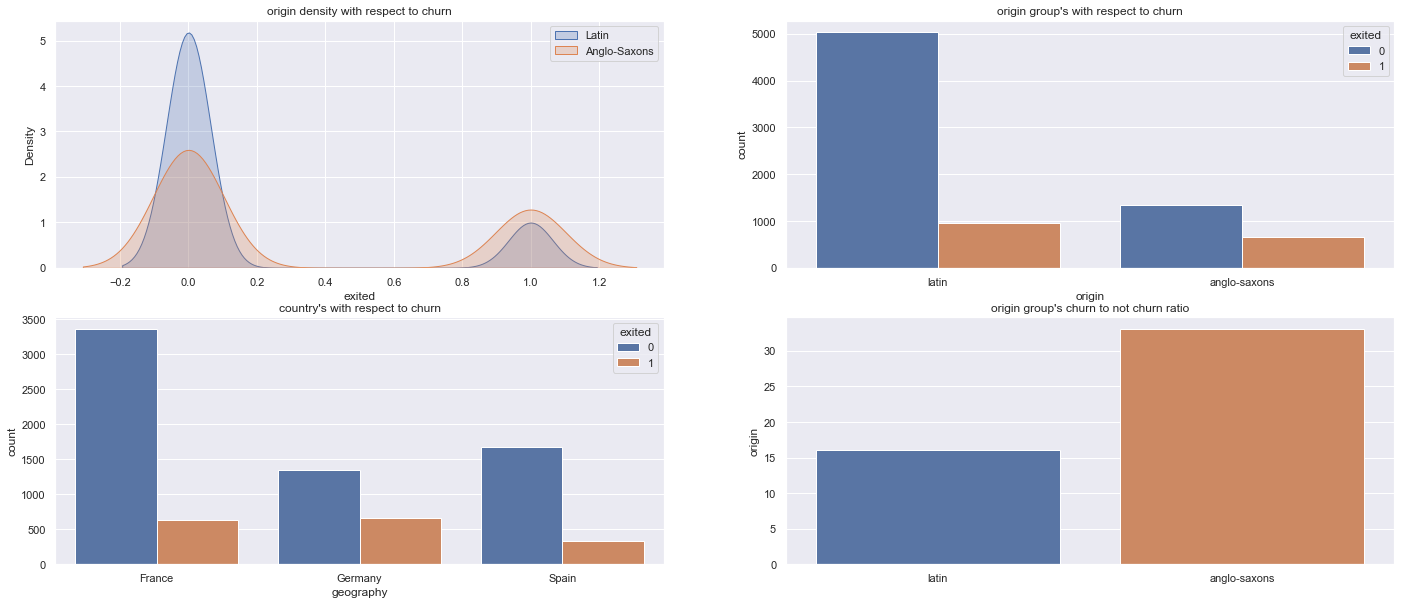

In [39]:
aux05 = df04_u[['origin', 'exited', 'geography']]

# figure size
plt.figure(figsize=(24,10))

# origin density
plt.subplot(2,2,1)
sns.kdeplot(aux05[aux05['origin'] == 'latin']['exited'], label='Latin', shade=True);
sns.kdeplot(aux05[aux05['origin'] == 'anglo-saxons']['exited'], label='Anglo-Saxons', shade=True);
plt.title("origin density with respect to churn");
plt.legend();

# origin group's
plt.subplot(2,2,2)
sns.countplot(x='origin', hue='exited', data=aux05).set_title("origin group's with respect to churn");

# country's plot
plt.subplot(2,2,3)
sns.countplot(x='geography', hue='exited', data=aux05).set_title("country's with respect to churn");

# origin group's churn to not churn ratio
plt.subplot(2,2,4)
aux05_ratio_churn = aux05[aux05['exited']==1]['origin'].value_counts()\
/ (aux05[aux05['exited']==0]['origin'].value_counts() + aux05[aux05['exited']==1]['origin'].value_counts())*100
sns.barplot(x=aux05_ratio_churn.index, y=aux05_ratio_churn).\
set_title("origin group's churn to not churn ratio");

### H06 - Active members should have less churn
---
> - Conclusion: **TRUE**
>> Active members have less churn

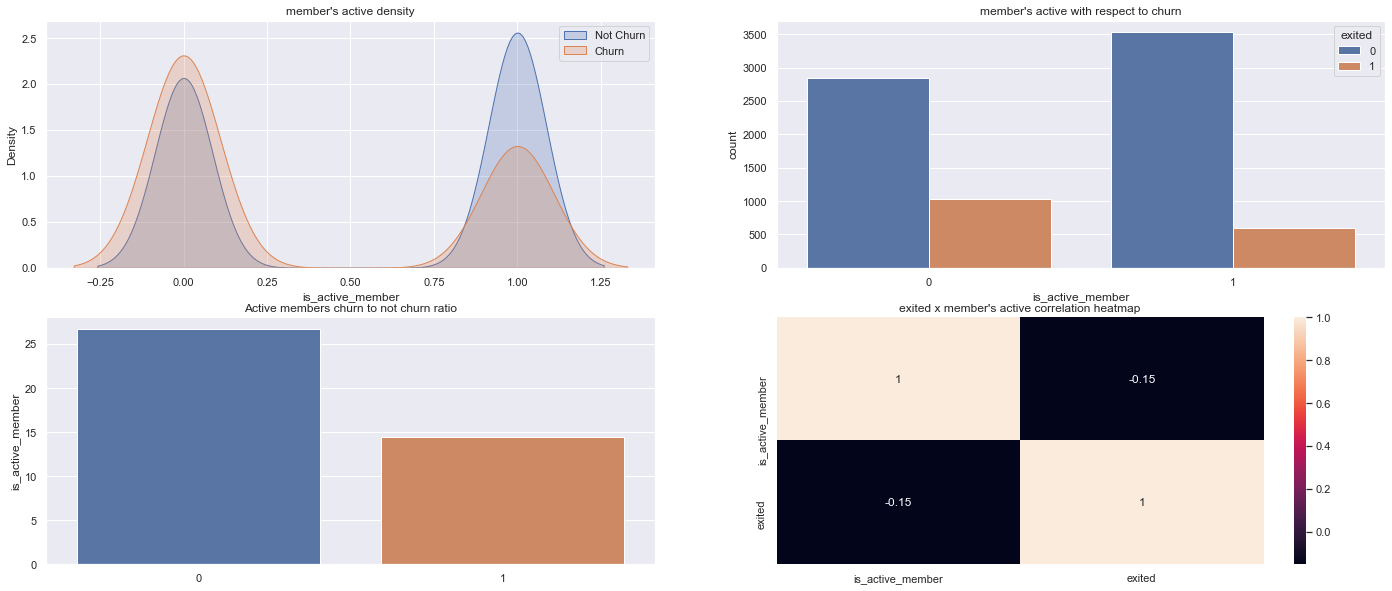

In [40]:
aux06 = df04_u[['is_active_member', 'exited']]

# figure size
plt.figure(figsize=(24,10))

# member's active density
plt.subplot(2,2,1)
sns.kdeplot(aux06[aux06['exited'] == 0]['is_active_member'], label='Not Churn', shade=True);
sns.kdeplot(aux06[aux06['exited'] == 1]['is_active_member'], label='Churn', shade=True);
plt.title("member's active density")
plt.legend()

# member's active with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='is_active_member', hue='exited', data=aux06).set_title("member's active with respect to churn");

# Active members churn to not churn ratio
plt.subplot(2,2,3)
aux06_ratio_churn = aux06[aux06['exited']==1]['is_active_member'].value_counts()\
                                            / (aux06[aux06['exited']==0]['is_active_member'].value_counts() + aux06[aux06['exited']==1]['is_active_member'].value_counts())*100
sns.barplot(x=aux06_ratio_churn.index, y=aux06_ratio_churn).\
set_title("Active members churn to not churn ratio");

# exited x member's active correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux06.corr(method='pearson'),annot=True);
plt.title("exited x member's active correlation heatmap");

### H07 - Churn should occur for customers with low tenure
---
> - Conclusion: **FALSE** 
>> Churn occur for customers with high tenur

<Figure size 1728x576 with 0 Axes>

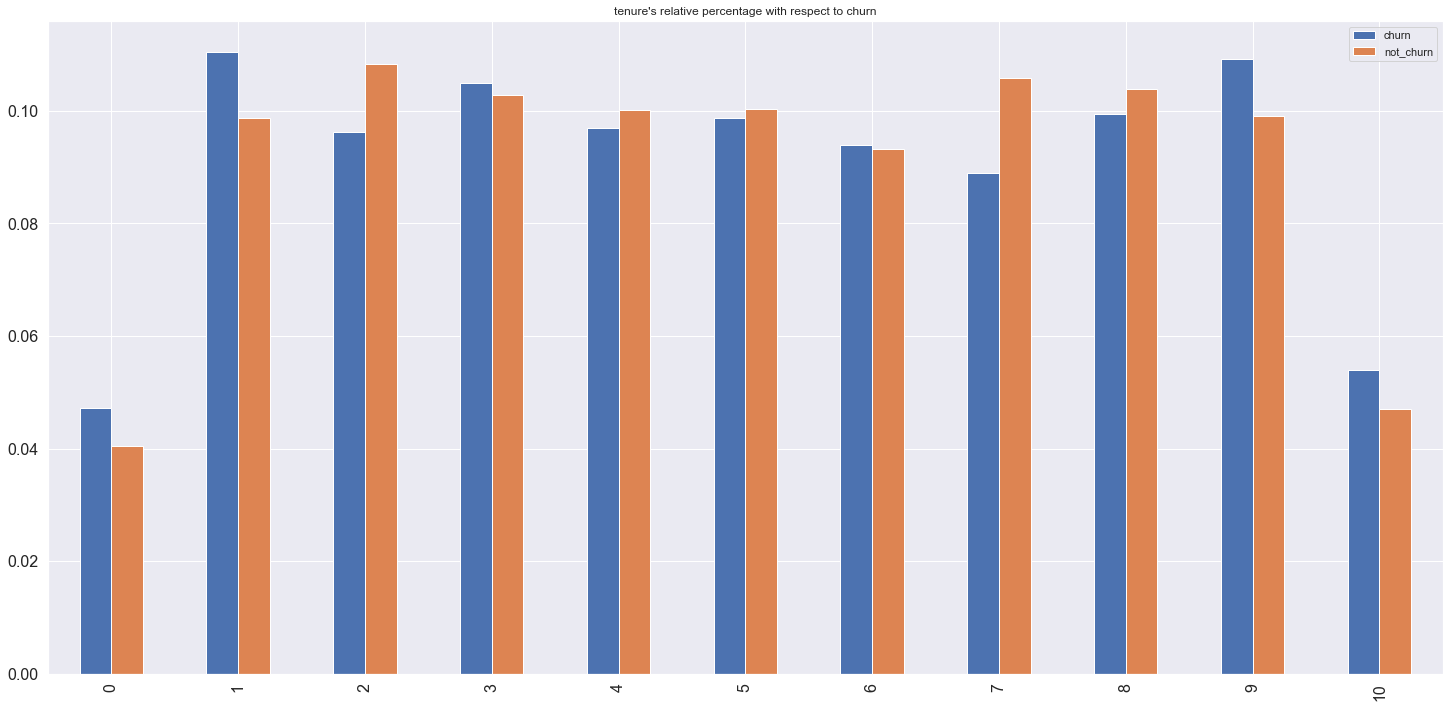

In [41]:
num_attributes = df04_u.select_dtypes(include=['int64', 'float64'])
tenure_percentage = num_attributes['tenure'].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn = pd.DataFrame()
tenure_percentage_hue_churn['churn'] = num_attributes['tenure'][num_attributes['exited'] == 1].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn['not_churn'] = num_attributes['tenure'][num_attributes['exited'] != 1].value_counts(normalize=True).sort_index()

# figure size
plt.figure(figsize=(24,8));

tenure_percentage_hue_churn.plot(kind='bar', stacked=False, fontsize=16);
plt.title("tenure's relative percentage with respect to churn");

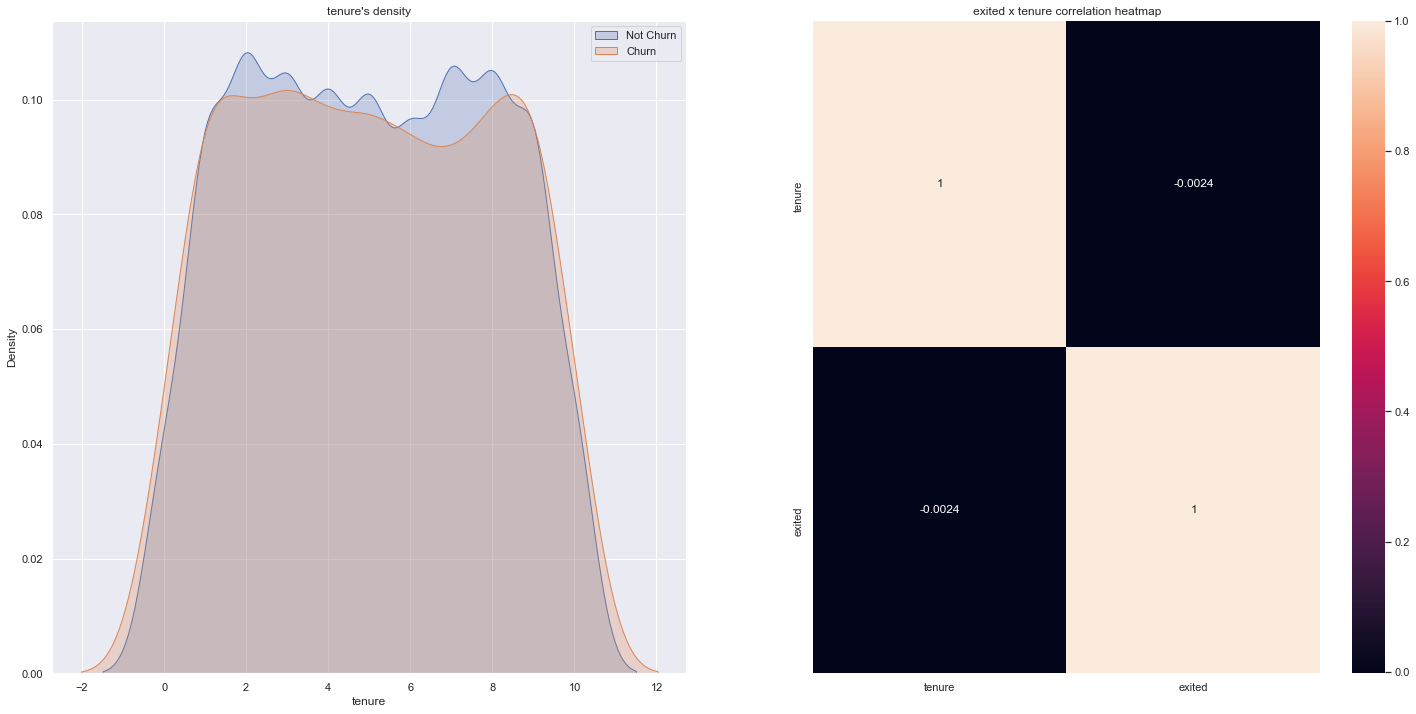

In [42]:
aux07 = df04_u[['tenure', 'exited']]

plt.subplot(1,2,1)
sns.kdeplot(aux07[aux07['exited'] == 0]['tenure'], label='Not Churn', shade=True);
sns.kdeplot(aux07[aux07['exited'] == 1]['tenure'], label='Churn', shade=True);
plt.title("tenure's density");
plt.legend();

plt.subplot(1,2,2)
sns.heatmap(aux07.corr(method='pearson'),annot=True);
plt.title("exited x tenure correlation heatmap");

### H08 - The more products the customer has, the less likely it is to go into churn
---
> - Conclusion: **FALSE** 
>> Customers with more than two products have a better chance of getting into churn

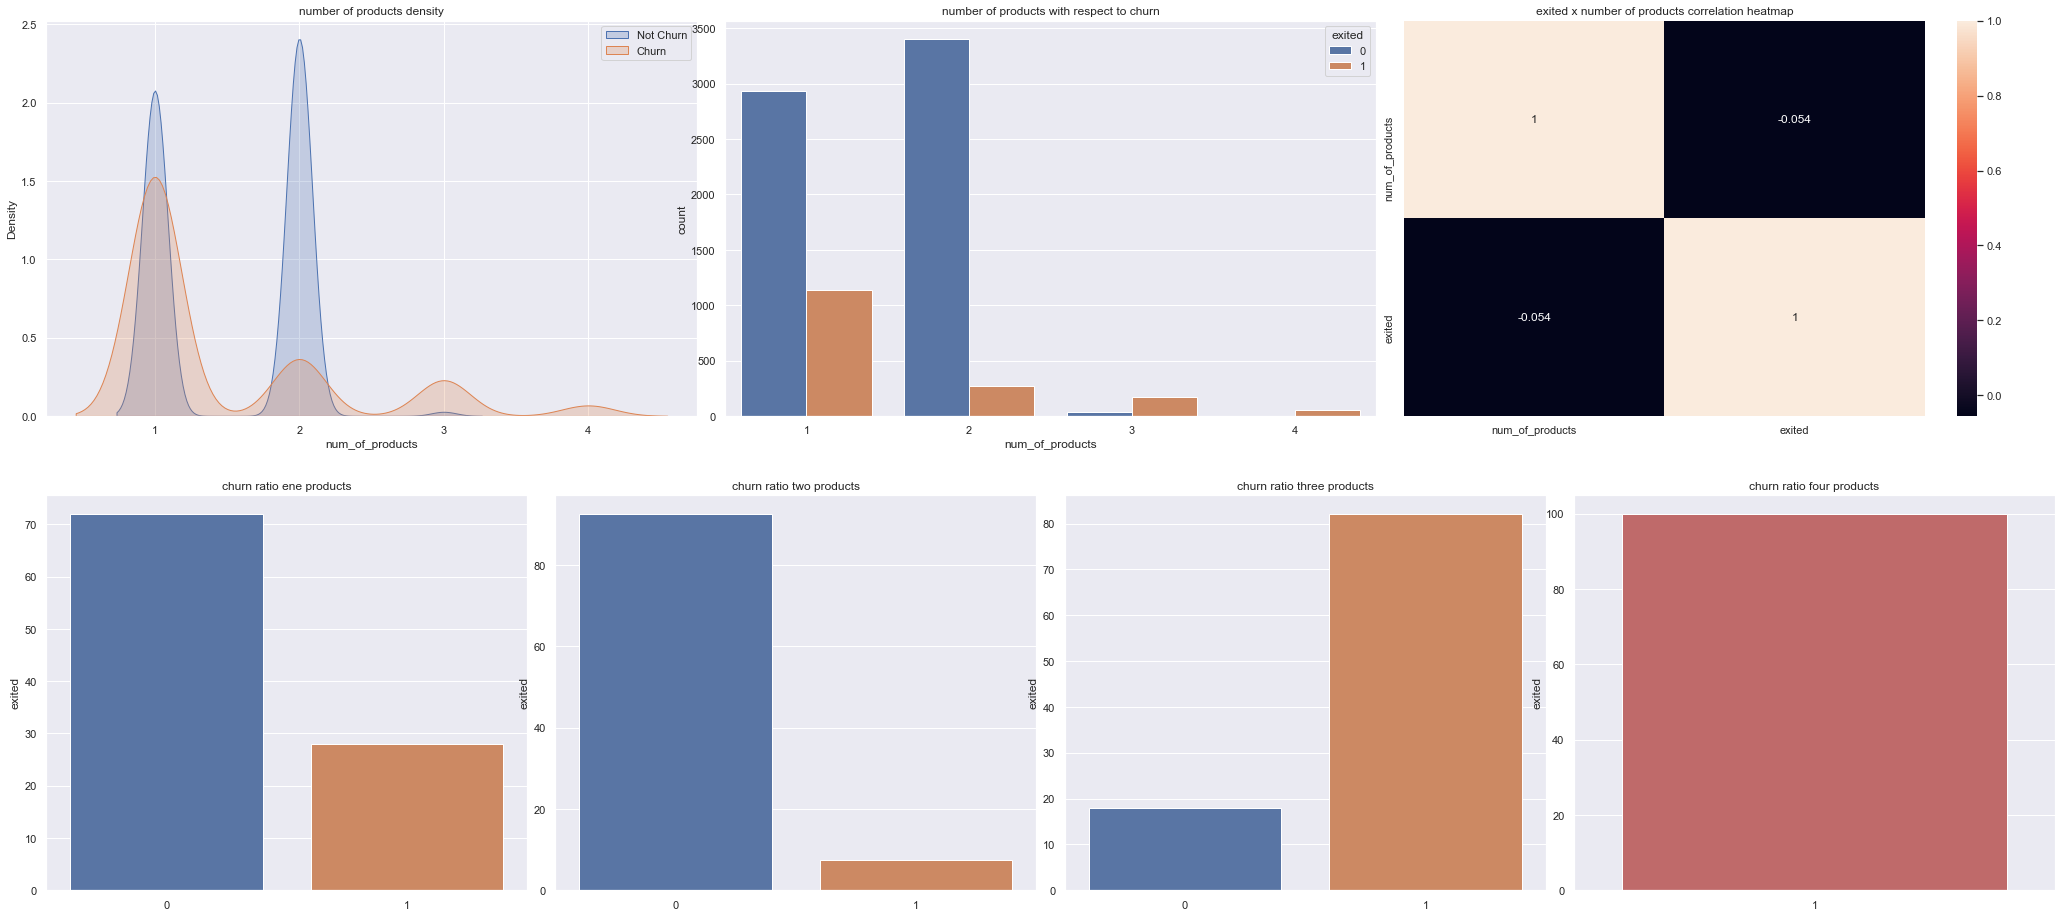

In [43]:
aux08 = df04_u[['num_of_products', 'exited']]

# Grid for ploting
plt.figure(figsize=(36,16))
grid = GridSpec(2, 12)

# number of products density
plt.subplot(grid[0,:4])
sns.kdeplot(aux08[aux08['exited'] == 0]['num_of_products'], label='Not Churn', shade=True);
sns.kdeplot(aux08[aux08['exited'] == 1]['num_of_products'], label='Churn', shade=True);
plt.title("number of products density");
plt.legend();

# number of products with respect to churn
plt.subplot(grid[0,4:8])
sns.countplot(x='num_of_products', hue='exited', data=aux08).set_title("number of products with respect to churn");

# exited x number of products correlation heatmap
plt.subplot(grid[0,8:12])
sns.heatmap(aux08.corr(method='pearson'),annot=True);
plt.title("exited x number of products correlation heatmap");

# churn ratio {num_of_products} products
dict_num_of_products = {
                            1: 'ene',
                            2: 'two',
                            3: 'three',
                            4: 'four'
                        }

for i in dict_num_of_products.keys():
    churn_prod = aux08[aux08['num_of_products']==i]['exited'].value_counts(normalize=True)*100
    if churn_prod.iloc[0] != 100:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));
    else:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, color='indianred',  y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));

### H09 - Customers with Credit Cards tend to stay at the bank
---
> - Conclusion: **TRUE** 
>> Customers who have a credit card have lower churn rate

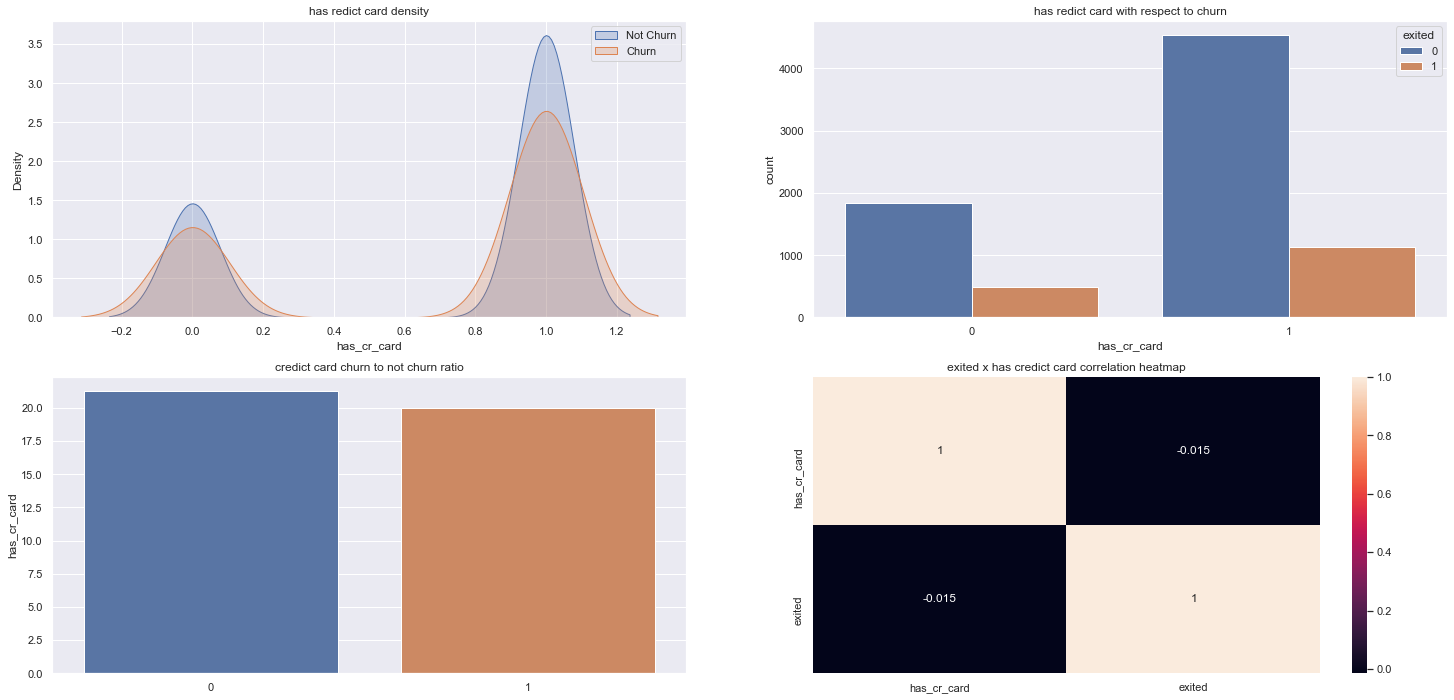

In [44]:
aux09 = df04_u[['has_cr_card', 'exited']]

# has redict card density
plt.subplot(2,2,1)
sns.kdeplot(aux09[aux09['exited'] == 0]['has_cr_card'], label='Not Churn', shade=True);
sns.kdeplot(aux09[aux09['exited'] == 1]['has_cr_card'], label='Churn', shade=True);
plt.title("has redict card density")
plt.legend()

# has redict card with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='has_cr_card', hue='exited', data=aux09).set_title("has redict card with respect to churn");

# credict card churn to not churn ratio
plt.subplot(2,2,3)
aux09_ratio_churn = aux09[aux09['exited']==1]['has_cr_card'].value_counts()\
                                                / (aux09[aux09['exited']==0]['has_cr_card'].value_counts() + aux09[aux09['exited']==1]['has_cr_card'].value_counts())*100
sns.barplot(x=aux09_ratio_churn.index, y=aux09_ratio_churn).\
set_title("credict card churn to not churn ratio");

# exited x has credict card correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux09.corr(method='pearson'),annot=True);
plt.title("exited x has credict card correlation heatmap");

## 4.6 Multivariate Analysis

### 4.6.1 Numerical Attributes

In [45]:
# Numerical Attributes and Boolean
num_attributes = df04.select_dtypes(include=['int64', 'float64'])

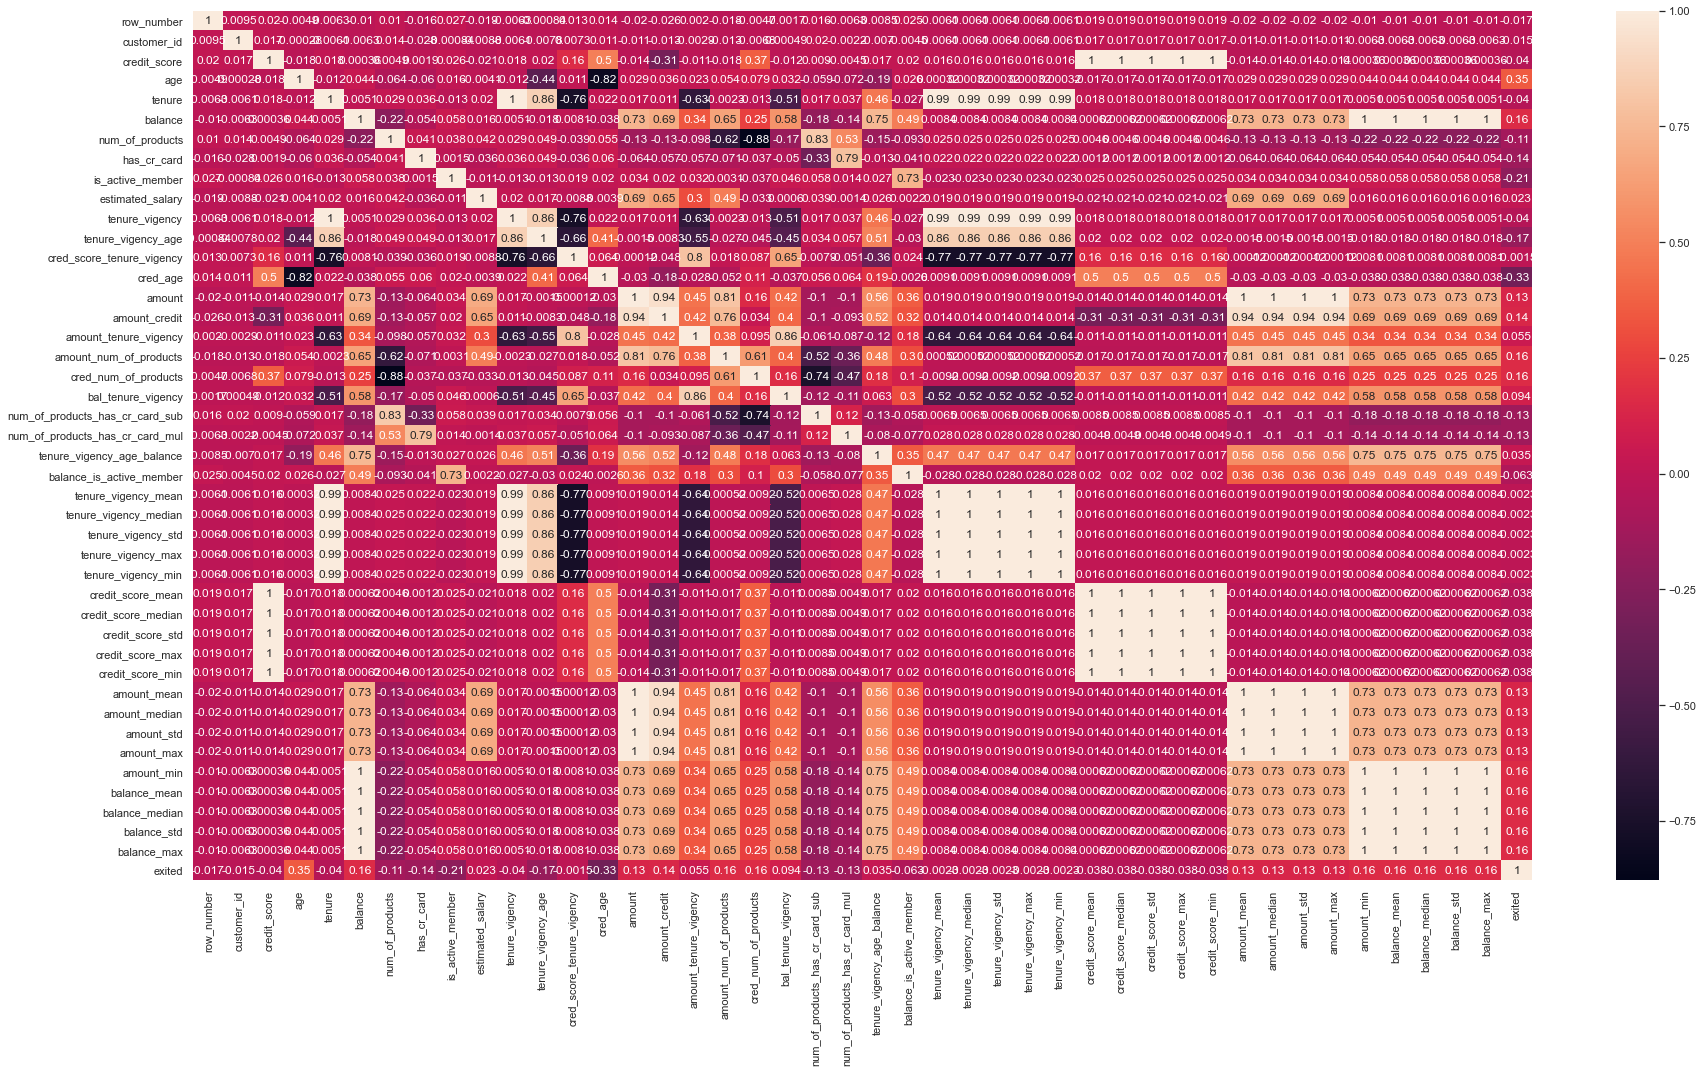

In [46]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(30,16));
sns.heatmap(correlation, annot=True);

### 4.6.2 Categorical Attributes

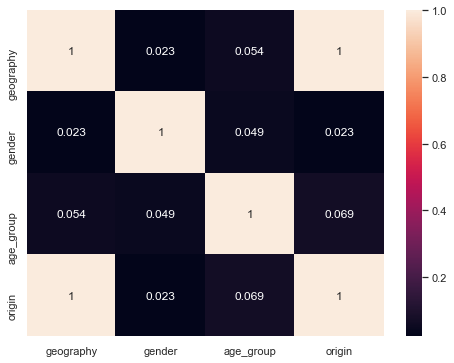

In [47]:
a1 = cramer_v(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramer_v(cat_attributes['geography'], cat_attributes['gender'])
a3 = cramer_v(cat_attributes['geography'], cat_attributes['age_group'])
a4 = cramer_v(cat_attributes['geography'], cat_attributes['origin'])

a5 = cramer_v(cat_attributes['gender'], cat_attributes['geography'])
a6 = cramer_v(cat_attributes['gender'], cat_attributes['gender'])
a7 = cramer_v(cat_attributes['gender'], cat_attributes['age_group'])
a8 = cramer_v(cat_attributes['gender'], cat_attributes['origin'])

a9 = cramer_v(cat_attributes['age_group'], cat_attributes['geography'])
a10 = cramer_v(cat_attributes['age_group'], cat_attributes['gender'])
a11 = cramer_v(cat_attributes['age_group'], cat_attributes['age_group'])
a12 = cramer_v(cat_attributes['age_group'], cat_attributes['origin'])

a13 = cramer_v(cat_attributes['origin'], cat_attributes['geography'])
a14 = cramer_v(cat_attributes['origin'], cat_attributes['gender'])
a15 = cramer_v(cat_attributes['origin'], cat_attributes['age_group'])
a16 = cramer_v(cat_attributes['origin'], cat_attributes['origin'])

#Final Dataset
dict_cramer_v = {
                'geography':[a1, a2, a3, a4],
                'gender':[a5, a6, a7, a8],
                'age_group':[a9, a10, a11, a12],
                'origin':[a13, a14, a15, a16]
                }

d = pd.DataFrame(dict_cramer_v)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True)
plt.show()

# 5.0 DATA PREPARATION

In [48]:
df05 = df04.copy()

In [49]:
# Numerical
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

## 5.1 Rescaling

## 5.2 Encoding

In [50]:
# Dummy variable
df05_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df05 = pd.concat([num_attributes, df05_dummy], axis=1)

## 5.3 Transformation

# 6.0 FEATURE SELECTION

In [51]:
df06 = df05.copy()

In [52]:
from sklearn.ensemble        import RandomForestClassifier
from boruta                  import BorutaPy
X = df06.drop(columns=['exited'], axis=1)
y = df06['exited'].copy()


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestClassifier(n_estimators=84, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x17A0753C740),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x17A0753C740, verbose=1)

In [53]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['row_number',
 'customer_id',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'tenure_vigency_age',
 'cred_score_tenure_vigency',
 'cred_age',
 'amount',
 'amount_credit',
 'amount_tenure_vigency',
 'amount_num_of_products',
 'cred_num_of_products',
 'bal_tenure_vigency',
 'num_of_products_has_cr_card_sub',
 'num_of_products_has_cr_card_mul',
 'tenure_vigency_age_balance',
 'balance_is_active_member',
 'tenure_vigency_std',
 'amount_mean',
 'amount_median',
 'amount_std',
 'amount_max',
 'amount_min',
 'balance_mean',
 'balance_median',
 'balance_std',
 'balance_max',
 'age_group_Midlife']

## 6.1 Split into Train and Validation

In [54]:
cols_selected = [#'row_number',
                 #'customer_id',
                 'age',
                 'balance',
                 'num_of_products',
                 'is_active_member',
                 'estimated_salary',
                 'tenure_vigency_age',
                 'cred_score_tenure_vigency',
                 'cred_age',
                 'amount_credit',
                 'amount_tenure_vigency',
                 'amount_num_of_products',
                 'cred_num_of_products',
                 'bal_tenure_vigency',
                 'num_of_products_has_cr_card_sub',
                 'num_of_products_has_cr_card_mul',
                 'tenure_vigency_age_balance',
                 'balance_is_active_member',
                 'tenure_vigency_mean',
                 #'tenure_vigency_max',
                 #'tenure_vigency_min',
                 'credit_score_min',
                 'amount_min',
                 'balance_mean',
                 #'balance_median',
                 #'balance_std',
                 #'balance_max',
                 'age_group_Midlife']


X = df06[cols_selected]
y = df06['exited'].copy()


# Split into Train and Validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=32)

# 7.0 MACHINE LEARNING MODEL

## 7.1 Baseline model (Random)

In [55]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_valid.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 7.1.1 Baseline Performance

Accuracy: 0.5147540983606558
Balanced Accuracy: 0.5072406172456576
Kappa Score: 0.01449655051960519
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1536
           1       0.45      0.44      0.45      1209

    accuracy                           0.51      2745
   macro avg       0.51      0.51      0.51      2745
weighted avg       0.51      0.51      0.51      2745



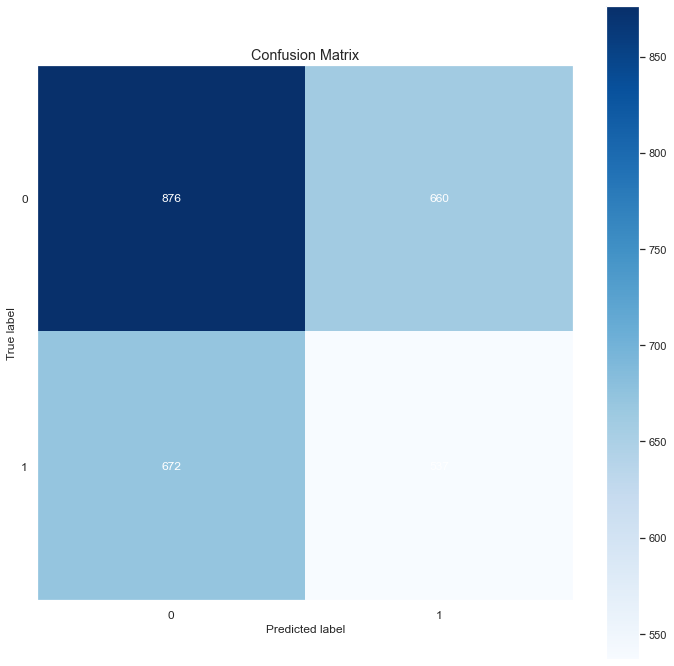

In [56]:
# Accuracy
acc_random = accuracy_score(y_valid, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_valid, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_valid, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_valid, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_random, normalize=False, figsize=(12, 12));

## 7.2 Machine Learning Model

### 7.2.1 Random Forest

In [57]:
# Model
rf = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_valid)

#### 7.2.1.1 Performance

Accuracy: 0.7591985428051001
Balanced Accuracy: 0.7423054306244831
Kappa Score: 0.4979834341962083
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1536
           1       0.80      0.60      0.69      1209

    accuracy                           0.76      2745
   macro avg       0.77      0.74      0.75      2745
weighted avg       0.77      0.76      0.75      2745



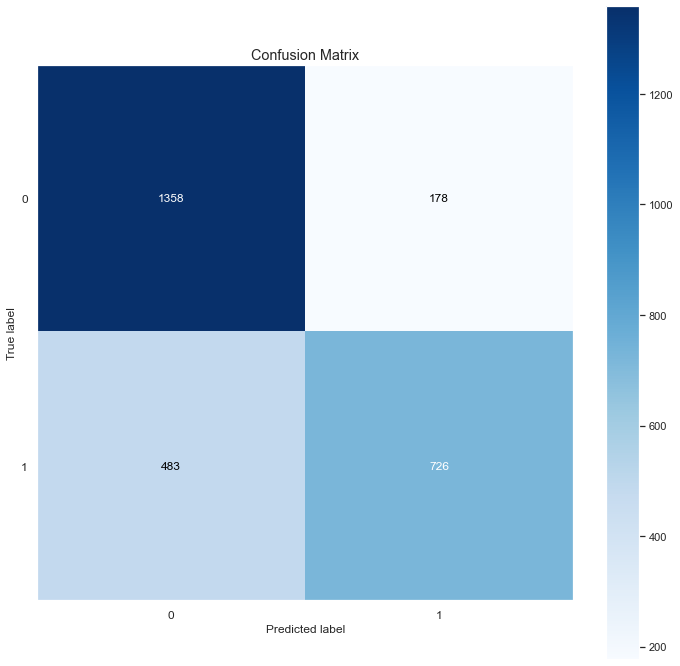

In [58]:
# Accuracy
acc_rf = accuracy_score(y_valid, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_valid, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_valid, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_valid, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_rf, normalize=False, figsize=(12, 12));

#### 7.2.1.2 Performance - Cross Validation

In [59]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)

# cross validation
result_rf = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.7902 +/- 0.0046,0.5953 +/- 0.0084,0.679 +/- 0.0058,0.4892 +/- 0.0075,0.7374 +/- 0.0038,0.7875 +/- 0.0077,0.8299 +/- 0.0046


### 7.2.2 XGBoost Classifier

In [60]:
xgb = XGBClassifier(max_depth=2, n_jobs=-1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_valid)

#### 7.2.2.1 Performance

Accuracy: 0.8320582877959927
Balanced Accuracy: 0.8259869016232424
Kappa Score: 0.6567732790656233
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1536
           1       0.83      0.78      0.80      1209

    accuracy                           0.83      2745
   macro avg       0.83      0.83      0.83      2745
weighted avg       0.83      0.83      0.83      2745



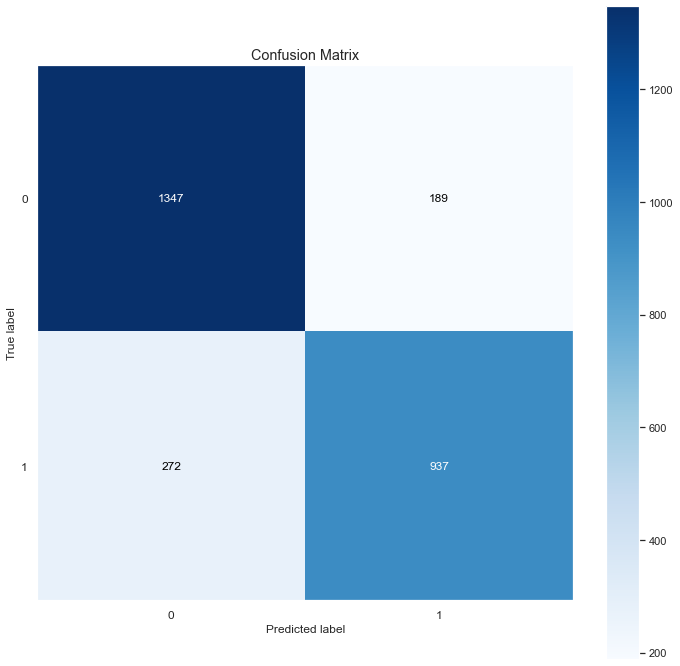

In [61]:
# Accuracy
acc_xgb = accuracy_score(y_valid, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = balanced_accuracy_score(y_valid, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Score
kappa_xgb = cohen_kappa_score(y_valid, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification Report
print(classification_report(y_valid, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_xgb, normalize=False, figsize=(12, 12));

#### 7.2.2.2 Performance - Cross Validation

In [62]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = XGBClassifier(max_depth=2, n_jobs=-1, random_state=42, verbosity=0)

# cross validation
result_xgb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.8232 +/- 0.0079,0.7577 +/- 0.0066,0.7891 +/- 0.0052,0.6397 +/- 0.009,0.8168 +/- 0.0044,0.8863 +/- 0.0058,0.9037 +/- 0.0047


### 7.2.3 LightGBM Classifier

In [63]:
lgbm = LGBMClassifier(max_depth=2, n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)

# Prediction
yhat_lgbm = lgbm.predict(X_valid)

#### 7.2.3.1 Performance

Accuracy: 0.8010928961748633
Balanced Accuracy: 0.7922425881410257
Kappa Score: 0.5915686171917409
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1536
           1       0.81      0.72      0.76      1209

    accuracy                           0.80      2745
   macro avg       0.80      0.79      0.80      2745
weighted avg       0.80      0.80      0.80      2745



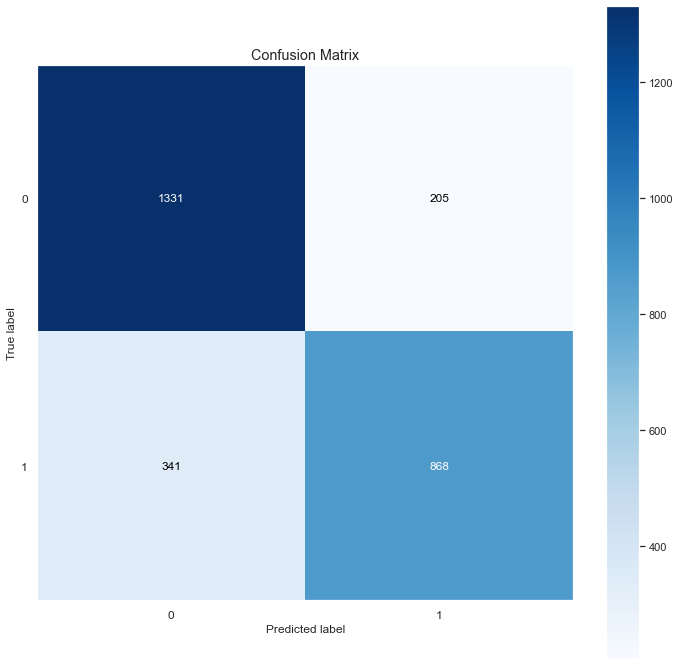

In [64]:
# Accuracy
acc_lgbm = accuracy_score(y_valid, yhat_lgbm)
print('Accuracy: {}'.format(acc_lgbm))

# Balanced Accuracy
balanced_acc_lgbm = balanced_accuracy_score(y_valid, yhat_lgbm)
print('Balanced Accuracy: {}'.format(balanced_acc_lgbm))

# Kappa Score
kappa_lgbm = cohen_kappa_score(y_valid, yhat_lgbm)
print('Kappa Score: {}'.format(kappa_lgbm))

# Classification Report
print(classification_report(y_valid, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lgbm, normalize=False, figsize=(12, 12));

#### 7.2.3.2 Performance - Cross Validation

In [65]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LGBMClassifier(max_depth=2, n_jobs=-1, random_state=42)

# cross validation
result_lgbm = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LGBMClassifier,0.8017 +/- 0.0073,0.7146 +/- 0.0068,0.7556 +/- 0.006,0.5875 +/- 0.01,0.7899 +/- 0.0049,0.8588 +/- 0.0066,0.8802 +/- 0.0049


### 7.2.4 Performance Comparison

In [66]:
df_compare = pd.concat([result_rf, result_xgb, result_lgbm], axis=0).reset_index(drop=True)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.7902 +/- 0.0046,0.5953 +/- 0.0084,0.679 +/- 0.0058,0.4892 +/- 0.0075,0.7374 +/- 0.0038,0.7875 +/- 0.0077,0.8299 +/- 0.0046
1,XGBClassifier,0.8232 +/- 0.0079,0.7577 +/- 0.0066,0.7891 +/- 0.0052,0.6397 +/- 0.009,0.8168 +/- 0.0044,0.8863 +/- 0.0058,0.9037 +/- 0.0047
2,LGBMClassifier,0.8017 +/- 0.0073,0.7146 +/- 0.0068,0.7556 +/- 0.006,0.5875 +/- 0.01,0.7899 +/- 0.0049,0.8588 +/- 0.0066,0.8802 +/- 0.0049


# 8.0 Hyperparameter Fine Tuning >> XGBoost

In [67]:
xgb_r = XGBClassifier(booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

In [73]:
 np.linspace(1e-3, 1e-2, 10)

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])

In [75]:
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 20, 1)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_child_weight = [2, 4, 5, 6, 8, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
#min_samples_leaf = [1, 2, 3, 4]

learning_rate = [float(x) for x in np.linspace(1e-3, 1e-2, 10)]

colsample_bytree = [float(x) for x in np.linspace(0.05, 1.0, 20)]

subsample = [float(x) for x in np.linspace(0.05, 1.0, 20)]

gamma = [int(x) for x in np.linspace(1, 6, 1)]

reg_lambda = [int(x) for x in np.linspace(1, 9, 1)]

reg_alpha = [int(x) for x in np.linspace(40, 150, 10)]


# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'learning_rate': learning_rate,
              'colsample_bytree': colsample_bytree,
              'subsample': subsample,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'reg_alpha': reg_alpha}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, None], 'min_child_weight': [2, 4, 5, 6, 8, 10], 'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01], 'colsample_bytree': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'subsample': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'gamma': [1], 'reg_lambda': [1], 'reg_alpha': [40, 52, 64, 76, 88, 101, 113, 125, 137, 150]}


In [77]:
from sklearn.model_selection import RandomizedSearchCV
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

xgb_r_random = RandomizedSearchCV(estimator=xgb_r, param_distributions=param_grid,
                              scoring='f1', n_iter=100, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [79]:
# fit the model
xgb_r_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 18.5min finished


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(bagging_freq=1, base_score=None,
                                           booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                                        'min_child_weight': [2, 4, 5, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                       

In [80]:
xgb_r_random.best_params_

{'subsample': 0.95,
 'reg_lambda': 1,
 'reg_alpha': 40,
 'n_estimators': 1000,
 'min_child_weight': 8,
 'max_depth': None,
 'learning_rate': 0.008,
 'gamma': 1,
 'colsample_bytree': 0.44999999999999996}

In [82]:
# Best estimator
xgb_r_tuned = xgb_r_random.best_estimator_
xgb_r_tuned

XGBClassifier(bagging_freq=1, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.44999999999999996, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.008, max_delta_step=0, max_depth=6,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=40, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [343]:
from skopt                   import forest_minimize
df_results_xgb = pd.DataFrame()


def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    reg_lambda        = params[7]
    reg_alpha         = params[8]

        
    #Model
    model = XGBClassifier(learning_rate=params[0], max_depth=None, min_child_weight=min_child_weight,subsample=params[3],
                                    colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7], reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)


    model.fit(X_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
    #roc_auc = roc_auc_score(y_valid, yhat_proba)
    #precision = precision_score(y_valid, yhat)
    f1 = f1_score(y_valid, yhat)
    
    return -f1 



space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 8), #min_child_weight
        (0.5, 1.0), #subsample
        (0.05, 0.5), #colsample_bytree
        (100, 500), #n_estimetors
        (1.0, 6.0), #gamma
        (0, 9), #reg_lambda
        (40, 150)]#reg_alpha



result = forest_minimize(tune_xgb, space, random_state=42, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.03918194347141743, 1, 3, 0.8898455001363847, 0.3185825710759192, 221, 1.7799726016810133, 7, 139]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3850
Function value obtained: -0.7480
Current minimum: -0.7480
Iteration No: 2 started. Evaluating function at random point.
[0.0019307837536547132, 1, 6, 0.5282057895135501, 0.37489944752007115, 393, 1.0038938292050716, 4, 72]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.1290
Function value obtained: -0.7121
Current minimum: -0.7480
Iteration No: 3 started. Evaluating function at random point.
[0.004059611610484304, 2, 5, 0.7159725093210579, 0.18105311308911887, 158, 2.999304858576278, 2, 147]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7240
Function value obtained: -0.6236
Current minimum: -0.7480
Iteration No: 4 started. Evaluating function at random point.
[0.010677482709481354, 2, 1, 0.5232252063599989

In [344]:
result_list_xgb = result.x
result_list_xgb
# [0.0616104953938097, 8, 7, 0.5447925470245325, 0.9631134231318818, 824, 0.19433864484474106]

[0.03804968634158327,
 1,
 5,
 0.9631504392566745,
 0.34298466147587503,
 127,
 5.315517129377969,
 7,
 51]

# 9.0 Final Model

In [345]:
params_xgb = result_list_xgb

lr                = params_xgb[0]
max_depth         = params_xgb[1]
min_child_weight  = params_xgb[2]
subsample         = params_xgb[3]
colsample_bytree  = params_xgb[4]
n_estimators      = params_xgb[5]
gamma             = params_xgb[6]
reg_lambda        = params_xgb[7]
reg_alpha         = params_xgb[8]

#Model
xgb = XGBClassifier(learning_rate=lr, max_depth=None, min_child_weight=min_child_weight, subsample=subsample,
                    colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)


xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_valid)

# Prediction proba
yhat_proba_xgb = xgb.predict_proba(X_valid)[:,1]

## 9.1 Final Model Performance

In [346]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_valid, yhat_xgb, yhat_proba_xgb)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.807229,0.72043,0.761364,0.591787,0.792507,0.841803,0.867755


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1536
           1       0.81      0.72      0.76      1209

    accuracy                           0.80      2745
   macro avg       0.80      0.79      0.80      2745
weighted avg       0.80      0.80      0.80      2745



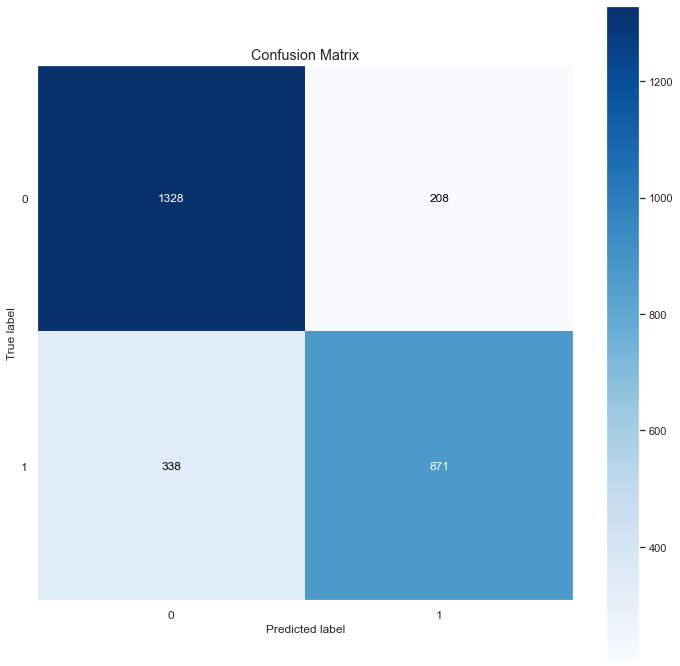

In [347]:
# Classification Report
print(classification_report(y_valid, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_xgb, normalize=False, figsize=(12, 12));

In [83]:
####### Teste
df_test = pd.read_feather('../01-Data/test_data.feather')

#========================================================= data cleaning =========================================================#
df_test = rename_columns(df_test)

#====================================================== feature Engineering ======================================================#
# Tenure Vigency
df_test['tenure_vigency'] = df_test['tenure'] + 1

# tenure_vigency / age
df_test['tenure_vigency_age'] = df_test['tenure_vigency'] / df_test['age']

# credit_score / tenure_vigency
df_test['cred_score_tenure_vigency'] = df_test['credit_score'] / df_test['tenure_vigency']

# credit_score / age
df_test['cred_age'] = df_test['credit_score'] / df_test['age']

# amount
df_test['amount'] = df_test['estimated_salary'] + df_test['balance']

# amount / credit_score
df_test['amount_credit'] = df_test['amount'] / df_test['credit_score']

# amount / tenure_vigency
df_test['amount_tenure_vigency'] = df_test['amount'] / df_test['tenure_vigency']

# amount / num_of_products
df_test['amount_num_of_products'] = df_test['amount'] / df_test['num_of_products']

# credit score / num_of_products
df_test['cred_num_of_products'] = df_test['credit_score'] / df_test['num_of_products']

# balance / tenure_vigency
df_test['bal_tenure_vigency'] = df_test['balance'] / df_test['tenure_vigency']

# num_of_products - credit card
df_test['num_of_products_has_cr_card_sub'] = df_test['num_of_products'] - df_test['has_cr_card']

# num_of_products * credit card
df_test['num_of_products_has_cr_card_mul'] = df_test['num_of_products'] * df_test['has_cr_card']

# tenure_vigency_age * balance
df_test['tenure_vigency_age_balance'] = df_test['tenure_vigency_age'] * df_test['balance']

# balance * is_active_member
df_test['balance_is_active_member'] = df_test['balance'] * df_test['is_active_member']

# Group Age
df_test['age_group'] = df_test['age'].apply(lambda row: age_stage(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df_test['origin'] = df_test['geography'].map(origin_map)




#################### tenure_vigency Mean, Median, Std, Max, Min
df_test['tenure_vigency_mean'] = df_test['tenure_vigency'] / df_test['tenure_vigency'].mean()
df_test['tenure_vigency_median'] = df_test['tenure_vigency'] / df_test['tenure_vigency'].median()
df_test['tenure_vigency_std'] = df_test['tenure_vigency'] / df_test['tenure_vigency'].std()
df_test['tenure_vigency_max'] = df_test['tenure_vigency'] / df_test['tenure_vigency'].max()
df_test['tenure_vigency_min'] = df_test['tenure_vigency'] / df_test['tenure_vigency'].min()

# credit_score Mean, Median, Std, Max, Min
df_test['credit_score_mean'] = df_test['credit_score'] / df_test['credit_score'].mean()
df_test['credit_score_median'] = df_test['credit_score'] / df_test['credit_score'].median()
df_test['credit_score_std'] = df_test['credit_score'] / df_test['credit_score'].std()
df_test['credit_score_max'] = df_test['credit_score'] / df_test['credit_score'].max()
df_test['credit_score_min'] = df_test['credit_score'] / df_test['credit_score'].min()

# amount Mean, Median, Std, Max, Min
df_test['amount_mean'] = df_test['amount'] / df_test['amount'].mean()
df_test['amount_median'] = df_test['amount'] / df_test['amount'].median()
df_test['amount_std'] = df_test['amount'] / df_test['amount'].std()
df_test['amount_max'] = df_test['amount'] / df_test['amount'].max()
df_test['amount_min'] = df_test['amount'] / df_test['amount'].min()

# balance Mean, Median, Std, Max, Min
df_test['balance_mean'] = df_test['balance'] / df_test['balance'].mean()
df_test['balance_median'] = df_test['balance'] / df_test['balance'].median()
df_test['balance_std'] = df_test['balance'] / df_test['balance'].std()
df_test['balance_max'] = df_test['balance'] / df_test['balance'].max()
df_test['amount_min'] = df_test['balance'] / df_test['balance'][df_test['balance'] > 0.0].min()


#====================================================== Data Preparation ======================================================#

# Numerical
num_attributes = df_test.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df_test.select_dtypes(exclude=['int64', 'float64'])
# Dummy variable
df_test_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df_test = pd.concat([num_attributes, df_test_dummy], axis=1)

cols_selected = [#'row_number',
                 #'customer_id',
                 'age',
                 'balance',
                 'num_of_products',
                 'is_active_member',
                 'estimated_salary',
                 'tenure_vigency_age',
                 'cred_score_tenure_vigency',
                 'cred_age',
                 'amount_credit',
                 'amount_tenure_vigency',
                 'amount_num_of_products',
                 'cred_num_of_products',
                 'bal_tenure_vigency',
                 'num_of_products_has_cr_card_sub',
                 'num_of_products_has_cr_card_mul',
                 'tenure_vigency_age_balance',
                 'balance_is_active_member',
                 'tenure_vigency_mean',
                 #'tenure_vigency_max',
                 #'tenure_vigency_min',
                 'credit_score_min',
                 'amount_min',
                 'balance_mean',
                 #'balance_median',
                 #'balance_std',
                 #'balance_max',
                 'age_group_Midlife']


X_test_eval = df_test[cols_selected]
y_test_eval = df_test['exited'].copy()

In [86]:
# Prediction
yhat_xgb_r_tuned_eval = xgb_r_tuned.predict(X_valid)

# Prediction proba
yhat_proba_xgb_r_tuned_eval = xgb_r_tuned.predict_proba(X_valid)[:,1]
yhat_proba_xgb_r_tuned_eval_2 = xgb_r_tuned.predict_proba(X_valid)

In [87]:
# Model Name
model_name = type(xgb_r_tuned).__name__

# Scores
final_scores = ml_scores(model_name, y_valid, yhat_xgb_r_tuned_eval, yhat_proba_xgb_r_tuned_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.818182,0.744417,0.779558,0.62016,0.807104,0.862337,0.884244


In [84]:
# Prediction
yhat_xgb_r_tuned_eval = xgb_r_tuned.predict(X_test_eval)

# Prediction proba
yhat_proba_xgb_r_tuned_eval = xgb_r_tuned.predict_proba(X_test_eval)[:,1]
yhat_proba_xgb_r_tuned_eval_2 = xgb_r_tuned.predict_proba(X_test_eval)

In [85]:
# Model Name
model_name = type(xgb_r_tuned).__name__

# Scores
final_scores = ml_scores(model_name, y_test_eval, yhat_xgb_r_tuned_eval, yhat_proba_xgb_r_tuned_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.556485,0.653563,0.60113,0.488742,0.76024,0.657673,0.843022


In [349]:
# Prediction
yhat_xgb_eval = xgb.predict(X_test_eval)

# Prediction proba
yhat_proba_xgb_eval = xgb.predict_proba(X_test_eval)[:,1]
yhat_proba_xgb_eval_2 = xgb.predict_proba(X_test_eval)

In [350]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_test_eval, yhat_xgb_eval, yhat_proba_xgb_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.566079,0.63145,0.59698,0.486855,0.753892,0.64008,0.841523


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.57      0.63      0.60       407

    accuracy                           0.83      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000



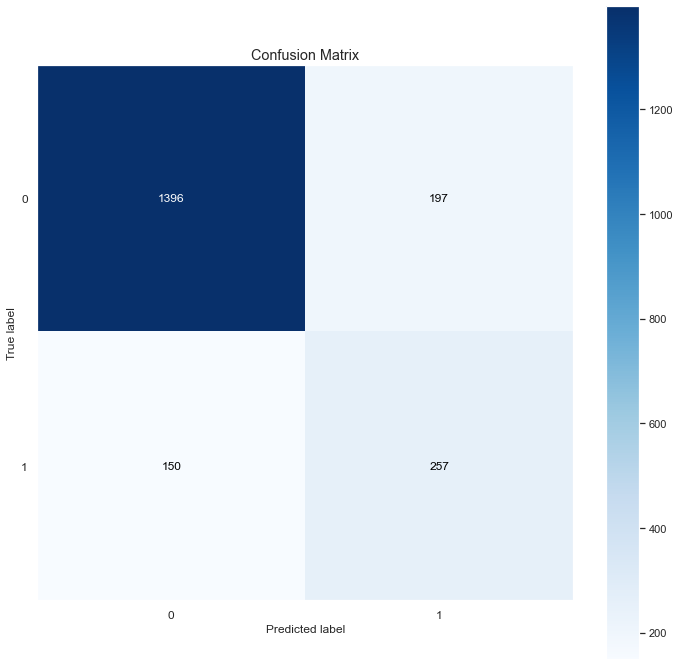

In [351]:
# Classification Report
print(classification_report(y_test_eval, yhat_xgb_eval))

# Confusion matrix
plot_confusion_matrix(y_test_eval, yhat_xgb_eval, normalize=False, figsize=(12, 12));